# Baseline Results Analysis

This notebook consists of an analysis based on BLEU and WER

In [1]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
import os
import unittest
from datasets import load_dataset
import matplotlib.pyplot as plt
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
    ...
    Methods
    -------
    parse_txt(path)
        Parses a txt file and returns a list of strings
    fix_format(sentence)
        Fixes the formatting of a sentence
    save_as_txt(path)
        Saves the data as a txt file
    save_as_csv(path)
        Saves the data as a csv file
    save_as_docx(path)
        Saves the data as a docx file
    get_data()
        Returns the data
    create_deepcopy()
        Returns a deepcopy of the DataLoader instance
    get_name()
        Returns the dataset name
    get_number_of_sentences()
        Returns the number of sentences in the data
    get_number_of_words()
        Returns the number of words in the data
    get_number_of_letters()
        Returns the number of letters in the data
    edit_distance(reference_sentence, sentence)
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
    get_edit_distance(reference, manual_wer=False)
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
    get_individual_edit_distance(reference)
        Returns the number of edits required to transform data into reference at word level for each individual sentence
    combine_nested_dict(dict1, dict2)
        Combines two nested dictionaries
    combine_dicts(dict1, dict2)
        Combines two dictionaries
    get_bleue_score(reference)
        Returns bleu score of the data against a reference
    get_wer(reference)
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
    get_bert_score(reference)
        Returns the BERTScore similarity score of the data against a reference
    get_LaBSE(reference, model=None, tokenizer=None)
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
    ...

    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])

    def edit_distance(reference_sentence, sentence):
        """
        Returns the number of edits required to transform reference_sentence into sentence at word level
        edits include insertions, deletions and substitutions
        based on levenshtein distance
        also returns a dictionary of substitutions, insertions and deletions
        """
        substitutions = 0
        insertions = 0
        deletions = 0
        substitution_dict = {}
        insertion_dict = {}
        deletion_dict = {}
        #remove punctuation and split into words
        sentence = re.sub(r'[^\w\s]','',sentence).lower().split()
        reference_sentence = re.sub(r'[^\w\s]','',reference_sentence).lower().split()
        #create matrix
        matrix = np.zeros((len(reference_sentence)+1,len(sentence)+1))
        #fill in first row and column
        for i in range(len(reference_sentence)+1):
            matrix[i][0] = i
        for j in range(len(sentence)+1):
            matrix[0][j] = j
        #fill in rest of matrix
        for i in range(1,len(reference_sentence)+1):
            for j in range(1,len(sentence)+1):
                if sentence[j-1] == reference_sentence[i-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(matrix[i-1][j-1], matrix[i-1][j], matrix[i][j-1])+1
        #backtrack to find edits
        i = len(reference_sentence)
        j = len(sentence)
        while i > 0 and j > 0:
            if sentence[j-1] == reference_sentence[i-1]:
                i -= 1
                j -= 1
            else:
                if matrix[i][j] == matrix[i-1][j-1]+1:
                    substitutions += 1
                    if reference_sentence[i-1] not in substitution_dict:
                        substitution_dict[reference_sentence[i-1]] = {sentence[j-1]:1}
                    else:
                        if sentence[j-1] not in substitution_dict[reference_sentence[i-1]]:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] = 1
                        else:
                            substitution_dict[reference_sentence[i-1]][sentence[j-1]] += 1
                    i -= 1
                    j -= 1
                elif matrix[i][j] == matrix[i-1][j]+1:
                    deletions += 1
                    if reference_sentence[i-1] not in deletion_dict:
                        deletion_dict[reference_sentence[i-1]] = 1
                    else:
                        deletion_dict[reference_sentence[i-1]] += 1
                    i -= 1
                elif matrix[i][j] == matrix[i][j-1]+1:
                    insertions += 1
                    if sentence[j-1] not in insertion_dict:
                        insertion_dict[sentence[j-1]] = 1
                    else:
                        insertion_dict[sentence[j-1]] += 1
                    j -= 1
        while i > 0:
            deletions += 1
            if reference_sentence[i-1] not in deletion_dict:
                deletion_dict[reference_sentence[i-1]] = 1
            else:
                deletion_dict[reference_sentence[i-1]] += 1
            i -= 1
        while j > 0:
            insertions += 1
            if sentence[j-1] not in insertion_dict:
                insertion_dict[sentence[j-1]] = 1
            else:
                insertion_dict[sentence[j-1]] += 1
            j -= 1
        distance = substitutions+insertions+deletions
        return substitutions, insertions, deletions, substitution_dict, insertion_dict, deletion_dict, distance
        
    def get_edit_distance(self, reference, manual_wer=False):
        """
        Returns the number of edits required to transform data into reference at word level, substitutions, insertions and deletions the associated dictionaries
        and the WER (withouth alignment) if manual_wer is set to True
        """
        if type(reference) == list:
            substitutions = 0
            insertions = 0
            deletions = 0
            all_sub = {}
            all_ins = {}
            all_del = {}
            distance = 0
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, dist = DataLoader.edit_distance(reference[i], self.data[i], )
                all_sub = self.combine_nested_dict(all_sub, substitution_dict)
                all_ins = self.combine_dicts(all_ins, insertion_dict)
                all_del = self.combine_dicts(all_del, deletion_dict)
                substitutions += sub
                insertions += ins
                deletions += dele
                distance += dist
            if manual_wer:
                return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance, distance/(sum([len(sentence.split()) for sentence in reference]))
            return substitutions, insertions, deletions, all_sub, all_ins, all_del, distance
        elif type(reference) == DataLoader:
            return self.get_edit_distance(reference.get_data(), manual_wer=manual_wer)
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_individual_edit_distance(self, reference):
        """
        Returns the number of edits required to transform data into reference at word level for each individual sentence
        """
        if type(reference) == list:
            output = []
            for i in range(len(self.data)):
                sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance = DataLoader.edit_distance(reference[i], self.data[i], )
                output.append((sub, ins, dele, substitution_dict, insertion_dict, deletion_dict, distance))
            return output
        elif type(reference) == DataLoader:
            return self.get_individual_edit_distance(reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")       

    def combine_nested_dict(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                for key2 in dict2[key]:
                    if key2 not in dict1[key]:
                        dict1[key][key2] = dict2[key][key2]
                    else:
                        dict1[key][key2] += dict2[key][key2]
        return dict1
    
    def combine_dicts(self, dict1, dict2):
        for key in dict2:
            if key not in dict1:
                dict1[key] = dict2[key]
            else:
                dict1[key] += dict2[key]
        return dict1

    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        """
        Returns the Word Error Rate (WER) of the data against a reference. With word alignment
        """
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")


    def get_bert_score(self, reference):
        """
        Returns the BERTScore similarity score of the data against a reference.
        """
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(), lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_LaBSE(self, reference, model=None, tokenizer=None):
        """
        Returns the LaBSE similarity score of the data against a reference which is a l2 norm between the reference and target sentences score.
        Score of 1 means the sentences are identical, closer to 0 means they are less similar semantically.
        """
        if model is None:
            model = BertModel.from_pretrained("setu4993/LaBSE")
        if tokenizer is None:
            tokenizer = BertTokenizerFast.from_pretrained("setu4993/LaBSE")
        if type(reference) == list:
            pass
        elif type(reference) == DataLoader:
            reference = reference.get_data()
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
        target = self.data
        reference_inputs = tokenizer(reference, return_tensors="pt", padding=True).to("cuda")
        target_inputs = tokenizer(target, return_tensors="pt", padding=True).to("cuda")
        with torch.no_grad():
            reference_outputs = model(**reference_inputs)
            target_outputs = model(**target_inputs)
        reference_embeddings = reference_outputs.pooler_output
        target_embeddings = target_outputs.pooler_output
        return self.similarity(reference_embeddings, target_embeddings)



In [4]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("output_data/v1/aws"):
    temp = DataLoader(path="output_data/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("output_data/v2/aws"):
    temp = DataLoader(path="output_data/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

Loading data

In [6]:
azure_data_v1 = []
for filename in os.listdir("output_data/v1/azure"):
    temp = DataLoader(path="output_data/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("output_data/v2/azure"):
    temp = DataLoader(path="output_data/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("output_data/v1/google"):
    temp = DataLoader(path="output_data/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("output_data/v2/google"):
    temp = DataLoader(path="output_data/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("output_data/v1/gpt"):
    temp = DataLoader(path="output_data/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("output_data/v2/gpt"):
    temp = DataLoader(path="output_data/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)


In [ ]:
from datasets import load_dataset
dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

for i in range(len(dataset_wmt_enfr)):
    to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
    reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(data=reference_wmt14_fr, dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(data=to_translate_wmt14_en, dataset_name="wmt14_en")

Calculating BLEU and WER

In [ ]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")

In [ ]:
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

In [11]:
#lets get the sum of all bleu scores for each service
total = 0
for result in aws_bleu_scores_v1:
    total += result["bleu"]
print(f"Average BLEU score for AWS: {total/len(aws_bleu_scores_v1)}")
print(f"The sum of all V1 AWS BLEU scores is: {total*100}")
#print the standard deviation of the bleu scores
print(f"The standard deviation of the AWS BLEU scores is: {np.std([result['bleu'] for result in aws_bleu_scores_v1])}")

total = 0
for result in aws_bleu_scores_v2:
    total += result["bleu"]
print(f"Average BLEU score for AWS: {total/len(aws_bleu_scores_v2)}")
print(f"The sum of all V2 AWS BLEU scores is: {total*100}")
print(f"The standard deviation of the AWS BLEU scores is: {np.std([result['bleu'] for result in aws_bleu_scores_v2])}")

total = 0
for result in google_bleu_scores_v1:
    total += result["bleu"]
print(f"Average BLEU score for Google: {total/len(google_bleu_scores_v1)}")
print(f"The sum of all V1 Google BLEU scores is: {total*100}")
print(f"The standard deviation of the AWS BLEU scores is: {np.std([result['bleu'] for result in google_bleu_scores_v1])}")

total = 0
for result in google_bleu_scores_v2:
    total += result["bleu"]
print(f"Average BLEU score for Google: {total/len(google_bleu_scores_v2)}")
print(f"The sum of all V2 Google BLEU scores is: {total*100}")
print(f"The standard deviation of the AWS BLEU scores is: {np.std([result['bleu'] for result in google_bleu_scores_v2])}")

total = 0
for result in azure_bleu_scores_v1:
    total += result["bleu"]
print(f"Average BLEU score for Azure: {total/len(azure_bleu_scores_v1)}")
print(f"The sum of all V1 Azure BLEU scores is: {total*100}")
print(f"The standard deviation of the Azure BLEU scores is: {np.std([result['bleu'] for result in azure_bleu_scores_v1])}")

total = 0
for result in azure_bleu_scores_v2:
    total += result["bleu"]
print(f"Average BLEU score for Azure: {total/len(azure_bleu_scores_v2)}")
print(f"The sum of all V2 Azure BLEU scores is: {total*100}")
print(f"The standard deviation of the Azure BLEU scores is: {np.std([result['bleu'] for result in azure_bleu_scores_v2])}")

total = 0
for result in gpt_bleu_scores_v1:
    total += result["bleu"]
print(f"Average BLEU score for GPT: {total/len(gpt_bleu_scores_v1)}")
print(f"The sum of all V1 GPT BLEU scores is: {total*100}")
print(f"The standard deviation of the GPT BLEU scores is: {np.std([result['bleu'] for result in gpt_bleu_scores_v1])}")

total = 0
for result in gpt_bleu_scores_v2:
    total += result["bleu"]
print(f"Average BLEU score for GPT: {total/len(gpt_bleu_scores_v2)}")
print(f"The sum of all V2 GPT BLEU scores is: {total*100}")
print(f"The standard deviation of the GPT BLEU scores is: {np.std([result['bleu'] for result in gpt_bleu_scores_v2])}")




Average BLEU score for AWS: 0.4074722540552564
The sum of all V1 AWS BLEU scores is: 285.2305778386795
The standard deviation of the AWS BLEU scores is: 0.042890767478941494
Average BLEU score for AWS: 0.39931162248568897
The sum of all V2 AWS BLEU scores is: 199.6558112428445
The standard deviation of the AWS BLEU scores is: 0.030868612997674676
Average BLEU score for Google: 0.3924842443689841
The sum of all V1 Google BLEU scores is: 274.7389710582889
The standard deviation of the AWS BLEU scores is: 0.08053234464214575
Average BLEU score for Google: 0.39174270644439363
The sum of all V2 Google BLEU scores is: 195.87135322219683
The standard deviation of the AWS BLEU scores is: 0.03141729189155078
Average BLEU score for Azure: 0.3584182028993944
The sum of all V1 Azure BLEU scores is: 250.89274202957608
The standard deviation of the Azure BLEU scores is: 0.1247100512481839
Average BLEU score for Azure: 0.36321876376255274
The sum of all V2 Azure BLEU scores is: 181.60938188127636
The

In [12]:
#AVG WER
total = 0
for result in aws_wer_scores_v1:
    total += result
print(f"Average WER score for AWS: {total/len(aws_wer_scores_v1)}")

total = 0
for result in aws_wer_scores_v2:
    total += result
print(f"Average WER score for AWS: {total/len(aws_wer_scores_v2)}")

total = 0
for result in google_wer_scores_v1:
    total += result
print(f"Average WER score for Google: {total/len(google_wer_scores_v1)}")

total = 0
for result in google_wer_scores_v2:
    total += result
print(f"Average WER score for Google: {total/len(google_wer_scores_v2)}")

total = 0
for result in azure_wer_scores_v1:
    total += result
print(f"Average WER score for Azure: {total/len(azure_wer_scores_v1)}")

total = 0
for result in azure_wer_scores_v2:
    total += result
print(f"Average WER score for Azure: {total/len(azure_wer_scores_v2)}")

total = 0
for result in gpt_wer_scores_v1:
    total += result
print(f"Average WER score for GPT: {total/len(gpt_wer_scores_v1)}")

total = 0
for result in gpt_wer_scores_v2:
    total += result
print(f"Average WER score for GPT: {total/len(gpt_wer_scores_v2)}")



Average WER score for AWS: 0.5169174283291204
Average WER score for AWS: 0.5280311633054953
Average WER score for Google: 0.5221085746319687
Average WER score for Google: 0.5253403096206644
Average WER score for Azure: 0.5628122542265336
Average WER score for Azure: 0.5564202446491973
Average WER score for GPT: 0.5136318926944062
Average WER score for GPT: 0.512469634463626


In [1]:
swap_res = pd.read_csv("output_data/swap_results.csv")
swap_res.head()
#swap_red where p_letter and p_confusing_word are 0
homophone = swap_res[(swap_res["p_letter"] == 0) & (swap_res["p_confusing_word"] == 0)]
#swap_res where p_homophone and p_letter are 0
confusing_word = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_letter"] == 0)]
#swap_res where p_homophone and p_confusing_word are 0
letter = swap_res[(swap_res["p_homophone"] == 0) & (swap_res["p_confusing_word"] == 0)]
homophone.head()

,dataset,p_homophone,p_letter,p_confusing_word,homophones_injected,letters_swapped,confusing_words_injected,words_modified,sentences_changed,sentences,words,letters,percentage_sentences_changed,percentage_words_modified,percentage_words_swapped_for_homophones,percentage_words_swapped_for_confusing_words,percentage_letters_swapped
0,wmt14_en,0.00,0.0,0.0,0,0,0,0,0,3003,62336,362045,0.000000,0.000000,0.000000,0.0,0.0
442,wmt14_en,0.05,0.0,0.0,957,0,0,957,786,3003,62336,362045,26.173826,1.535228,1.535228,0.0,0.0
883,wmt14_en,0.10,0.0,0.0,1913,0,0,1913,1324,3003,62336,362045,44.089244,3.068853,3.068853,0.0,0.0
1324,wmt14_en,0.15,0.0,0.0,2787,0,0,2787,1710,3003,62336,362045,56.943057,4.470932,4.470932,0.0,0.0
1765,wmt14_en,0.20,0.0,0.0,3691,0,0,3691,2003,3003,62336,362045,66.699967,5.921137,5.921137,0.0,0.0


In [3]:
#combine homphone, confusing word and letter in one dataframe
combined = pd.concat([homophone, confusing_word, letter])
combined.to_csv("swap_results_combined.csv", index=False)

In [15]:
homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]

3.068852669

In [16]:
#aws in position 0, google in position 1, azure in position 2, gpt in position 3
baseline = [aws_bleu_scores_v1[0]['bleu'], google_bleu_scores_v1[0]['bleu'], azure_bleu_scores_v1[0]['bleu'], gpt_bleu_scores_v1[0]['bleu']]
confusing_word_10 = [aws_bleu_scores_v1[1]['bleu'], google_bleu_scores_v1[1]['bleu'], azure_bleu_scores_v1[1]['bleu'], gpt_bleu_scores_v1[3]['bleu']]
confusing_word_20 = [aws_bleu_scores_v1[2]['bleu'], google_bleu_scores_v1[2]['bleu'], azure_bleu_scores_v1[2]['bleu'], gpt_bleu_scores_v1[4]['bleu']]
confusing_letter_10 = [aws_bleu_scores_v1[3]['bleu'], google_bleu_scores_v1[3]['bleu'], azure_bleu_scores_v1[3]['bleu'], gpt_bleu_scores_v1[1]['bleu']]
confusing_letter_20 = [aws_bleu_scores_v1[4]['bleu'], google_bleu_scores_v1[4]['bleu'], azure_bleu_scores_v1[4]['bleu'], gpt_bleu_scores_v1[2]['bleu']]
homophone_10 = [aws_bleu_scores_v1[5]['bleu'], google_bleu_scores_v1[5]['bleu'], azure_bleu_scores_v1[5]['bleu'], gpt_bleu_scores_v1[5]['bleu']]
homophone_20 = [aws_bleu_scores_v1[6]['bleu'], google_bleu_scores_v1[6]['bleu'], azure_bleu_scores_v1[6]['bleu'], gpt_bleu_scores_v1[6]['bleu']]

confusing_word_35 = [aws_bleu_scores_v2[1]['bleu'], google_bleu_scores_v2[1]['bleu'], azure_bleu_scores_v2[1]['bleu'], gpt_bleu_scores_v2[2]['bleu']]
confusing_letter_5 = [aws_bleu_scores_v2[0]['bleu'], google_bleu_scores_v2[0]['bleu'], azure_bleu_scores_v2[0]['bleu'], gpt_bleu_scores_v2[1]['bleu']]
homophone_70 = [aws_bleu_scores_v2[3]['bleu'], google_bleu_scores_v2[3]['bleu'], azure_bleu_scores_v2[3]['bleu'], gpt_bleu_scores_v2[4]['bleu']]
homophone_35 = [aws_bleu_scores_v2[2]['bleu'], google_bleu_scores_v2[2]['bleu'], azure_bleu_scores_v2[2]['bleu'], gpt_bleu_scores_v2[3]['bleu']]
confusing_letter_2_5 = [aws_bleu_scores_v2[4]['bleu'], google_bleu_scores_v2[4]['bleu'], azure_bleu_scores_v2[4]['bleu'], gpt_bleu_scores_v2[0]['bleu']]

In [17]:
#same of above but for WER
baseline_wer = [aws_wer_scores_v1[0], google_wer_scores_v1[0], azure_wer_scores_v1[0], gpt_wer_scores_v1[0]]
confusing_word_10_wer = [aws_wer_scores_v1[1], google_wer_scores_v1[1], azure_wer_scores_v1[1], gpt_wer_scores_v1[3]]

confusing_letter_10_wer = [aws_wer_scores_v1[3], google_wer_scores_v1[3], azure_wer_scores_v1[3], gpt_wer_scores_v1[1]]
confusing_letter_20_wer = [aws_wer_scores_v1[4], google_wer_scores_v1[4], azure_wer_scores_v1[4], gpt_wer_scores_v1[2]]
homophone_10_wer = [aws_wer_scores_v1[5], google_wer_scores_v1[5], azure_wer_scores_v1[5], gpt_wer_scores_v1[5]]
homophone_20_wer = [aws_wer_scores_v1[6], google_wer_scores_v1[6], azure_wer_scores_v1[6], gpt_wer_scores_v1[6]]

#10% of words modified
confusing_word_20_wer = [aws_wer_scores_v1[2], google_wer_scores_v1[2], azure_wer_scores_v1[2], gpt_wer_scores_v1[4]]

#20% words modified
confusing_word_35_wer = [aws_wer_scores_v2[1], google_wer_scores_v2[1], azure_wer_scores_v2[1], gpt_wer_scores_v2[2]]

#20% of words modified
confusing_letter_5_wer = [aws_wer_scores_v2[0], google_wer_scores_v2[0], azure_wer_scores_v2[0], gpt_wer_scores_v2[1]]
#20% of words modified
homophone_70_wer = [aws_wer_scores_v2[3], google_wer_scores_v2[3], azure_wer_scores_v2[3], gpt_wer_scores_v2[4]]
#10% of words modified
homophone_35_wer = [aws_wer_scores_v2[2], google_wer_scores_v2[2], azure_wer_scores_v2[2], gpt_wer_scores_v2[3]]

#10% of words modified
confusing_letter_2_5_wer = [aws_wer_scores_v2[4], google_wer_scores_v2[4], azure_wer_scores_v2[4], gpt_wer_scores_v2[0]]

## Results Analysis

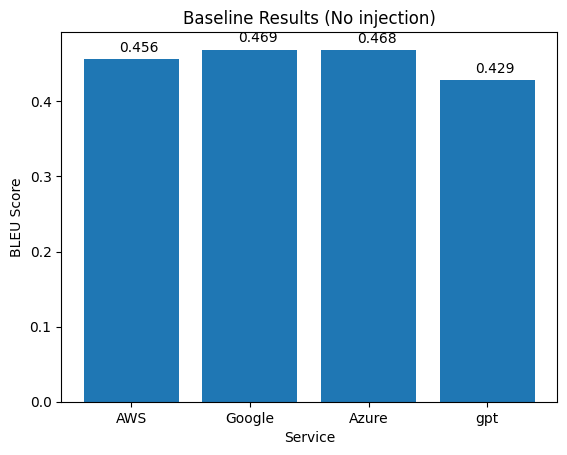

In [18]:
#Lets make a bar chart for each of the lists we just created
plt.bar(['AWS', 'Google', 'Azure', 'gpt'], baseline)
#add the values to the top of the bars round it to 3 decimal places
for i, v in enumerate(baseline):
    plt.text(i-.1, v+.01, str(round(v, 3)))
plt.title("Baseline Results (No injection)")
plt.ylabel("BLEU Score")
plt.xlabel("Service")
plt.show()


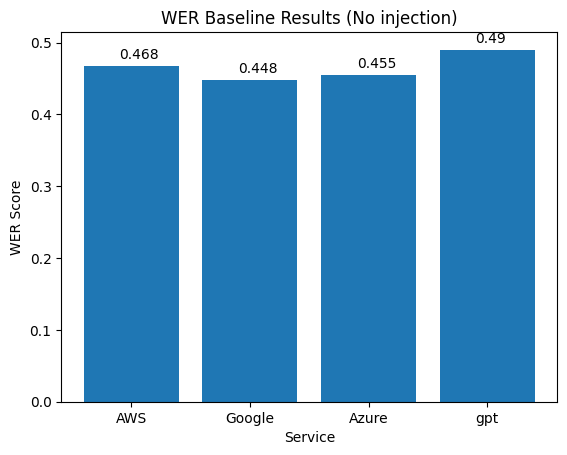

In [22]:
#same of above but for WER
plt.bar(['AWS', 'Google', 'Azure', 'gpt'], baseline_wer)
#add the values to the top of the bars round it to 3 decimal places
for i, v in enumerate(baseline_wer):
    plt.text(i-.1, v+.01, str(round(v, 3)))
plt.title("WER Baseline Results (No injection)")
plt.ylabel("WER Score")
plt.xlabel("Service")
plt.show()

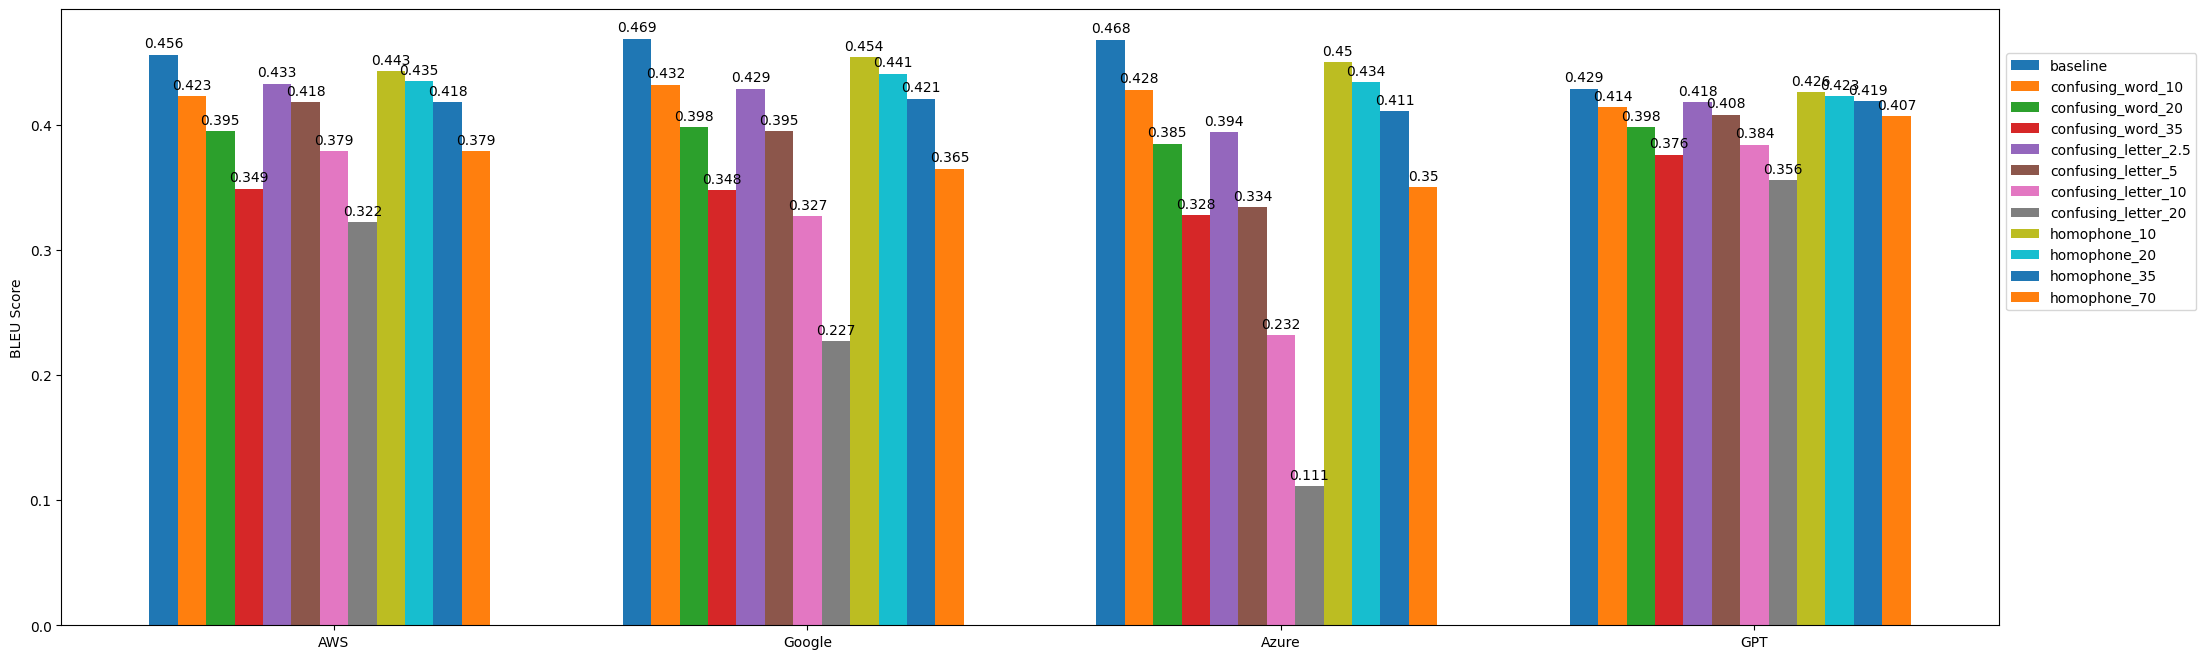

In [23]:
import numpy as np
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline,
    'confusing_word_10': confusing_word_10,
    'confusing_word_20': confusing_word_20,
    'confusing_word_35': confusing_word_35,
    'confusing_letter_2.5': confusing_letter_2_5,
    'confusing_letter_5': confusing_letter_5,
    'confusing_letter_10': confusing_letter_10,
    'confusing_letter_20': confusing_letter_20,
    'homophone_10': homophone_10,
    'homophone_20': homophone_20,
    'homophone_35': homophone_35,
    'homophone_70': homophone_70,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BLEU Score')
#ax.set_title('BLEU Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width*6, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



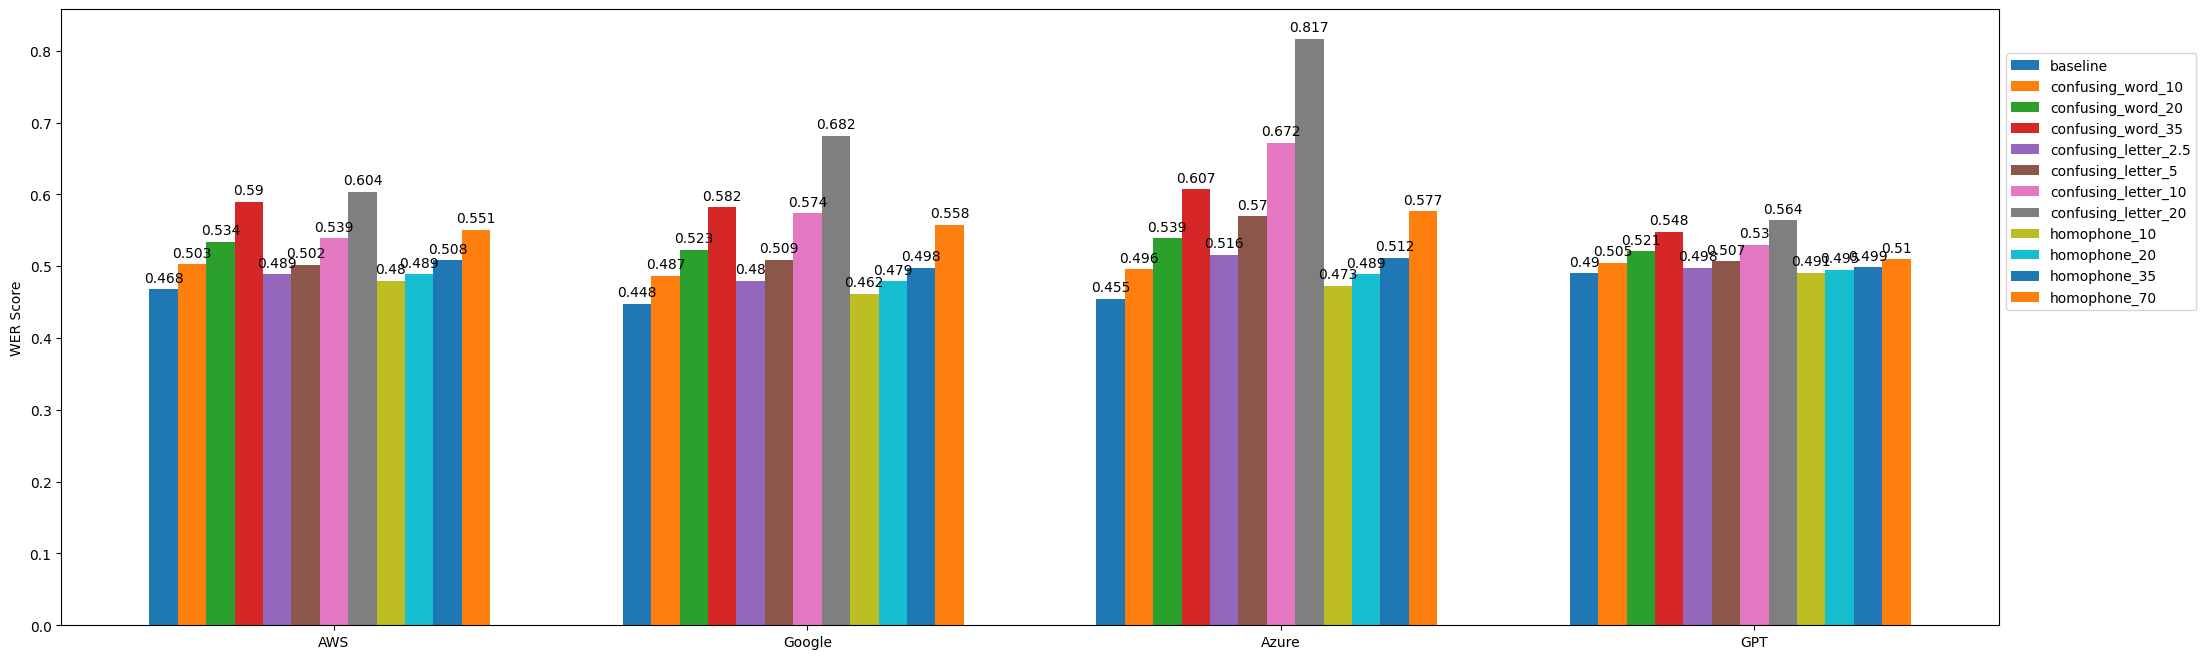

In [24]:
#same of above but for WER
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_wer,
    'confusing_word_10': confusing_word_10_wer,
    'confusing_word_20': confusing_word_20_wer,
    'confusing_word_35': confusing_word_35_wer,
    'confusing_letter_2.5': confusing_letter_2_5_wer,
    'confusing_letter_5': confusing_letter_5_wer,
    'confusing_letter_10': confusing_letter_10_wer,
    'confusing_letter_20': confusing_letter_20_wer,
    'homophone_10': homophone_10_wer,
    'homophone_20': homophone_20_wer,
    'homophone_35': homophone_35_wer,
    'homophone_70': homophone_70_wer,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('WER Score')
#ax.set_title('WER Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width*6, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


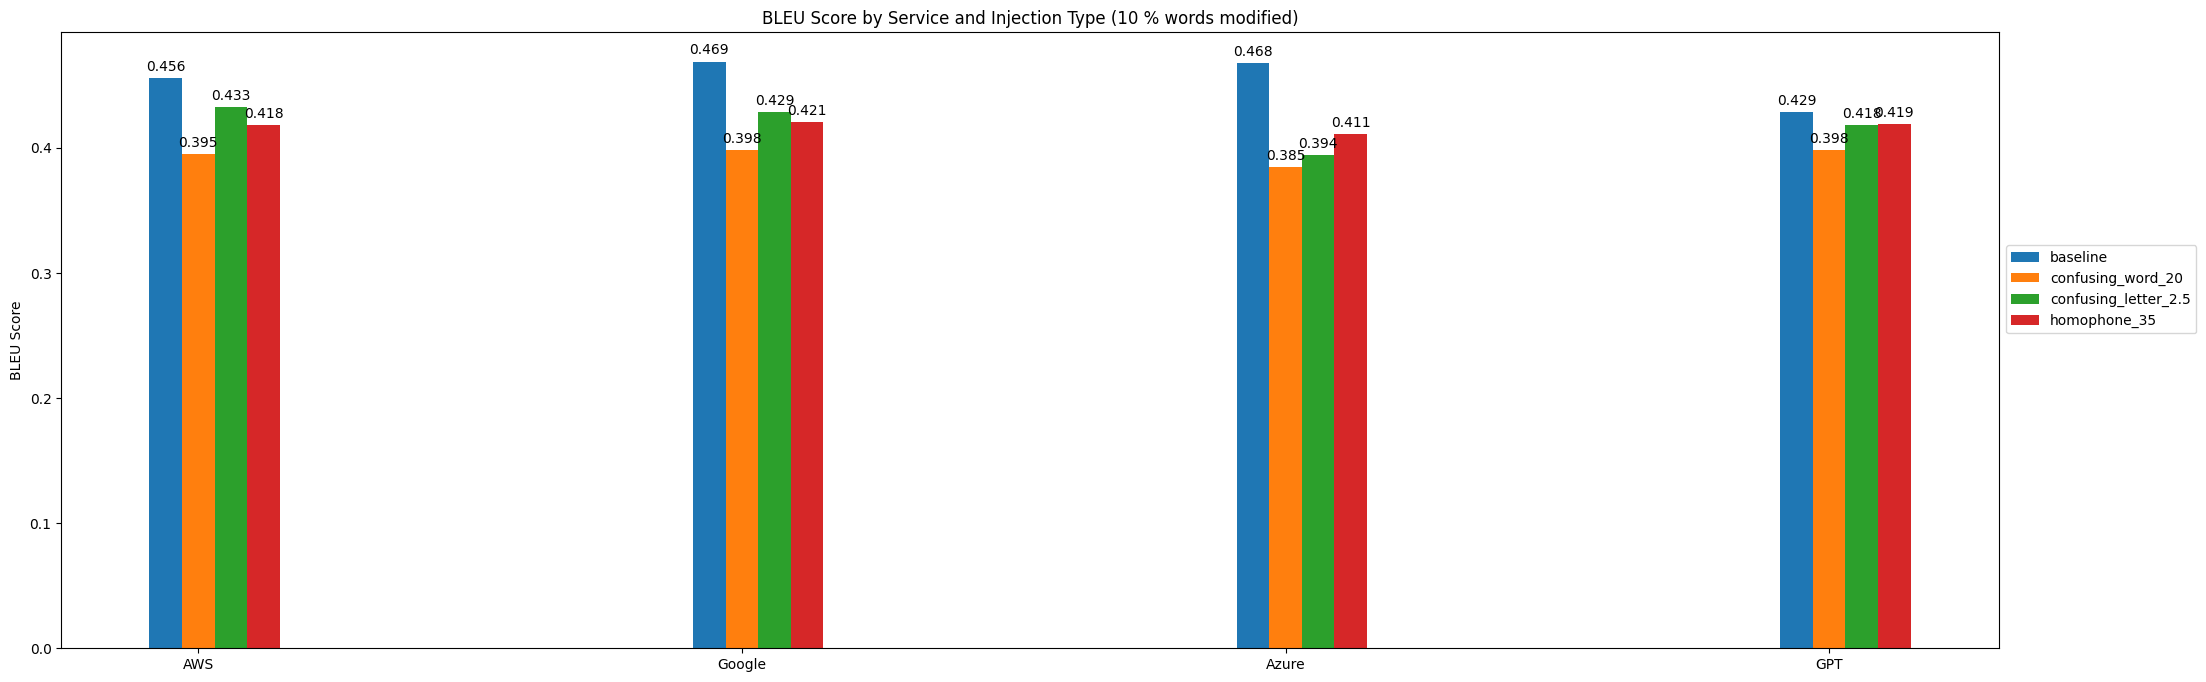

In [27]:
import numpy as np
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline,
    #'confusing_word_10': confusing_word_10,
    'confusing_word_20': confusing_word_20,
    #'confusing_word_35': confusing_word_35,
    'confusing_letter_2.5': confusing_letter_2_5,
    #'confusing_letter_5': confusing_letter_5,
    #'confusing_letter_10': confusing_letter_10,
    #'confusing_letter_20': confusing_letter_20,
    #'homophone_10': homophone_10,
    #'homophone_20': homophone_20,
    'homophone_35': homophone_35,
    #'homophone_70': homophone_70,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BLEU Score')
ax.set_title('BLEU Score by Service and Injection Type (10 % words modified)')
#center the x ticks
ax.set_xticks(x+width, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



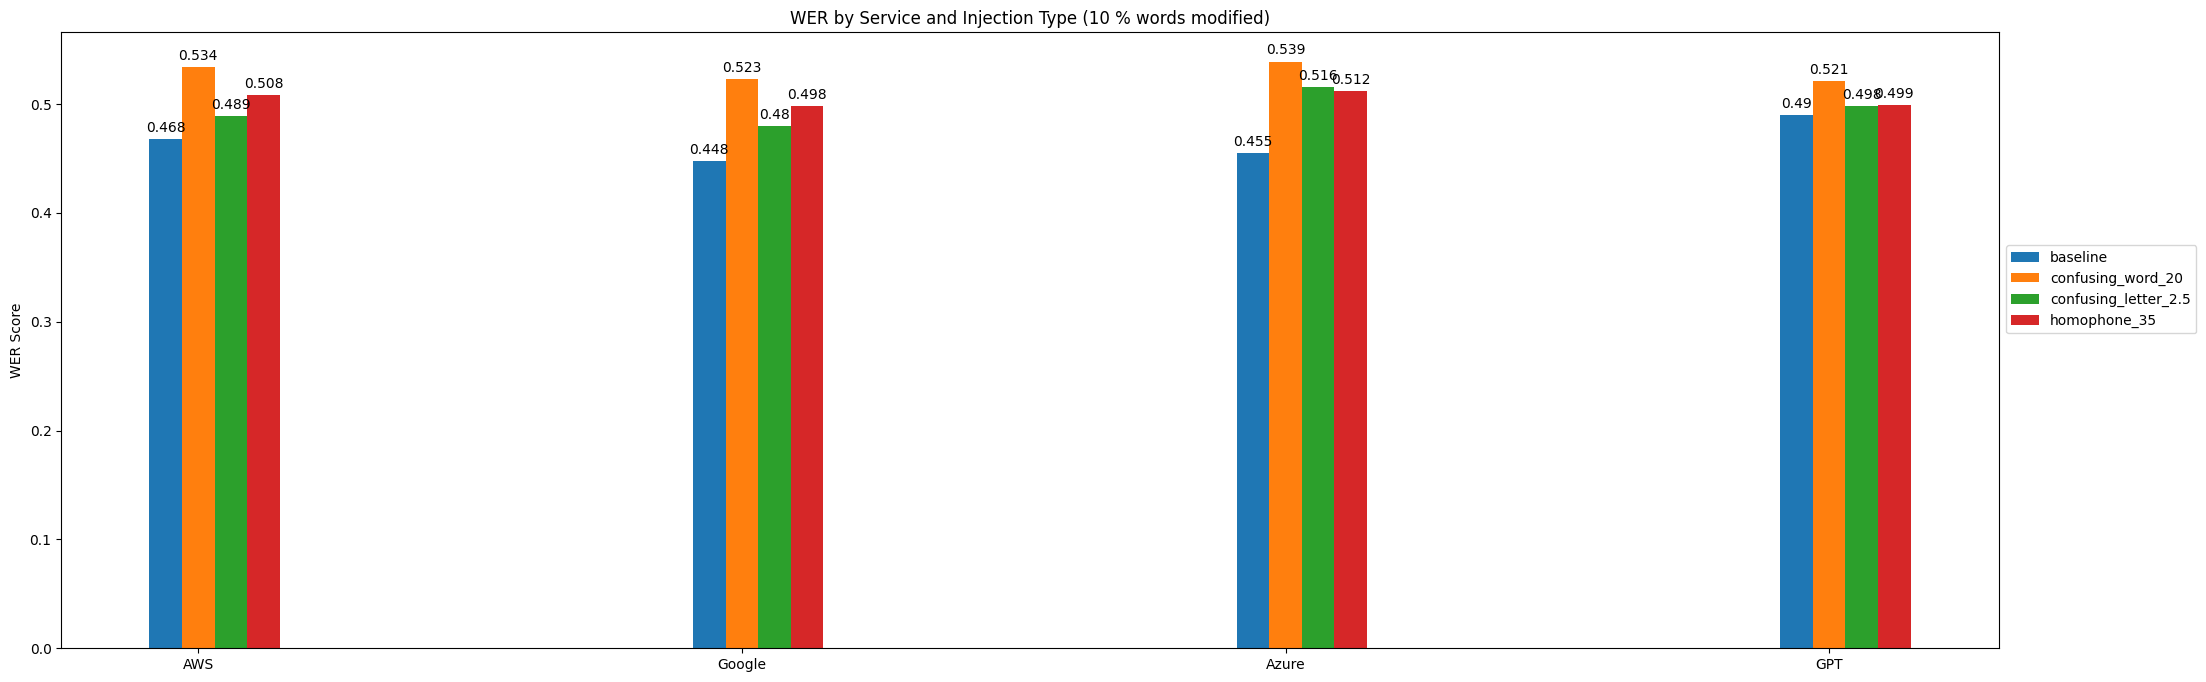

In [22]:
#same of above but for WER
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_wer,
    #'confusing_word_10': confusing_word_10_wer,
    'confusing_word_20': confusing_word_20_wer,
    #'confusing_word_35': confusing_word_35_wer,
    'confusing_letter_2.5': confusing_letter_2_5_wer,
    #'confusing_letter_5': confusing_letter_5_wer,
    #'confusing_letter_10': confusing_letter_10_wer,
    #'confusing_letter_20': confusing_letter_20_wer,
    #'homophone_10': homophone_10_wer,
    #'homophone_20': homophone_20_wer,
    'homophone_35': homophone_35_wer,
    #'homophone_70': homophone_70_wer,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('WER Score')
ax.set_title('WER by Service and Injection Type (10 % words modified)')
#center the x ticks
ax.set_xticks(x+width, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


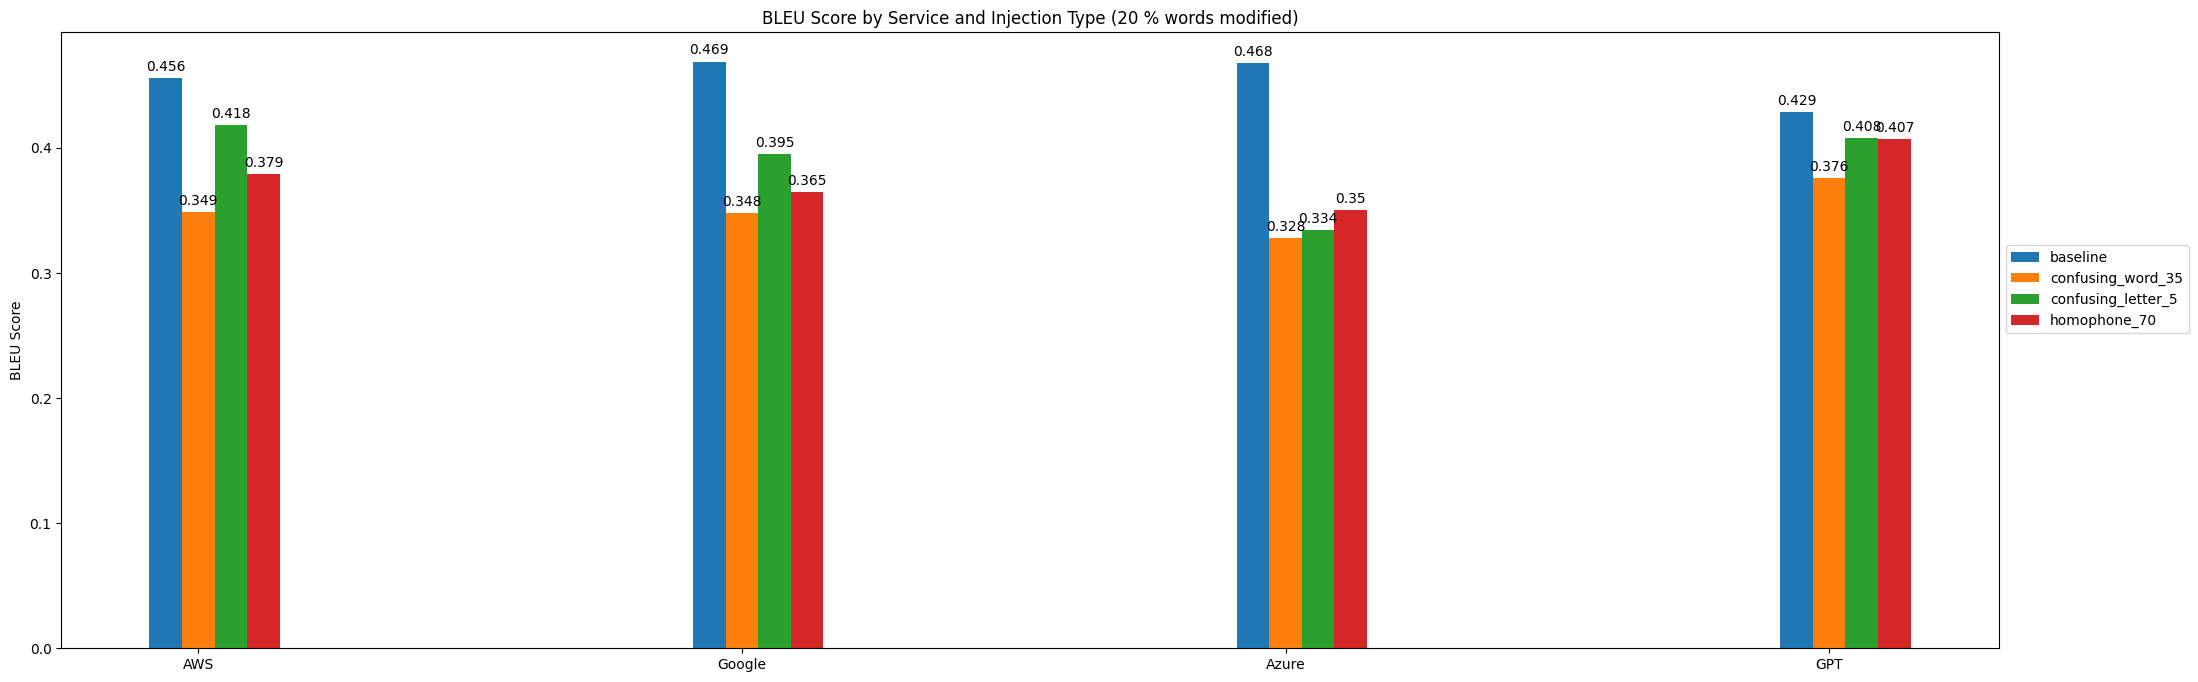

In [23]:
import numpy as np
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline,
    #'confusing_word_10': confusing_word_10,
    #'confusing_word_20': confusing_word_20,
    'confusing_word_35': confusing_word_35,
    #'confusing_letter_2.5': confusing_letter_2_5,
    'confusing_letter_5': confusing_letter_5,
    #'confusing_letter_10': confusing_letter_10,
    #'confusing_letter_20': confusing_letter_20,
    #'homophone_10': homophone_10,
    #'homophone_20': homophone_20,
    #'homophone_35': homophone_35,
    'homophone_70': homophone_70,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BLEU Score')
ax.set_title('BLEU Score by Service and Injection Type (20 % words modified)')
#center the x ticks
ax.set_xticks(x+width, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



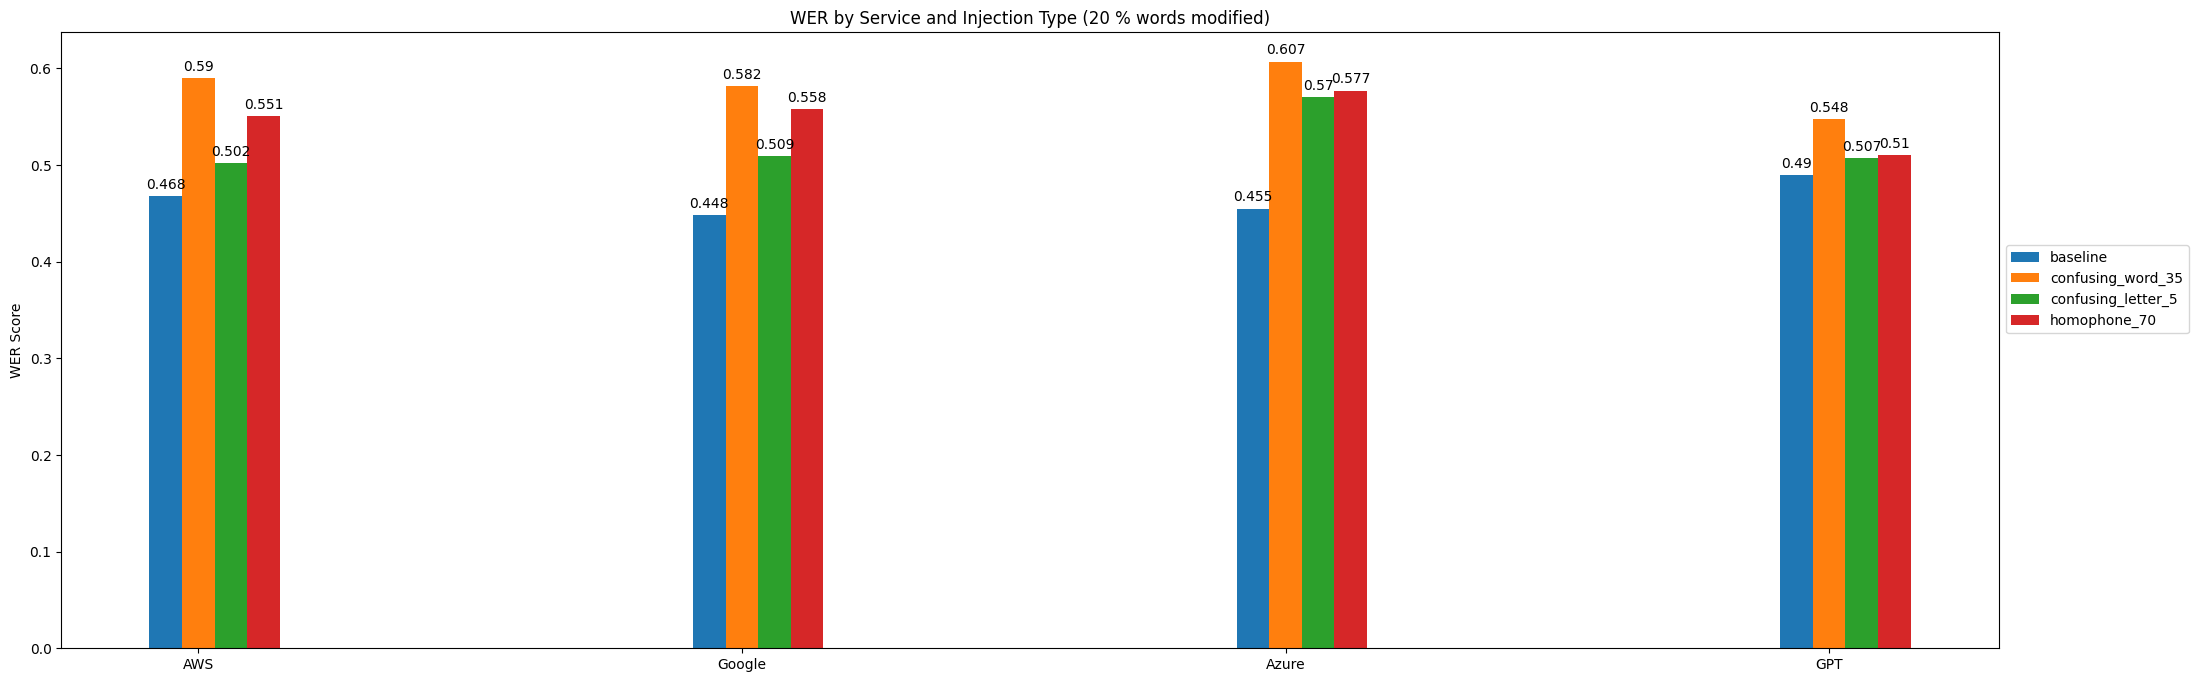

In [24]:
#same of above but for WER
services = ['AWS', 'Google', 'Azure', 'GPT']
all_data = {
    'baseline': baseline_wer,
    #'confusing_word_10': confusing_word_10_wer,
    #'confusing_word_20': confusing_word_20_wer,
    'confusing_word_35': confusing_word_35_wer,
    #'confusing_letter_2.5': confusing_letter_2_5_wer,
    'confusing_letter_5': confusing_letter_5_wer,
    #'confusing_letter_10': confusing_letter_10_wer,
    #'confusing_letter_20': confusing_letter_20_wer,
    #'homophone_10': homophone_10_wer,
    #'homophone_20': homophone_20_wer,
    #'homophone_35': homophone_35_wer,
    'homophone_70': homophone_70_wer,

}
x = np.arange(len(services))
width = 0.06
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('WER Score')
ax.set_title('WER by Service and Injection Type (20 % words modified)')
#center the x ticks
ax.set_xticks(x+width, services)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()


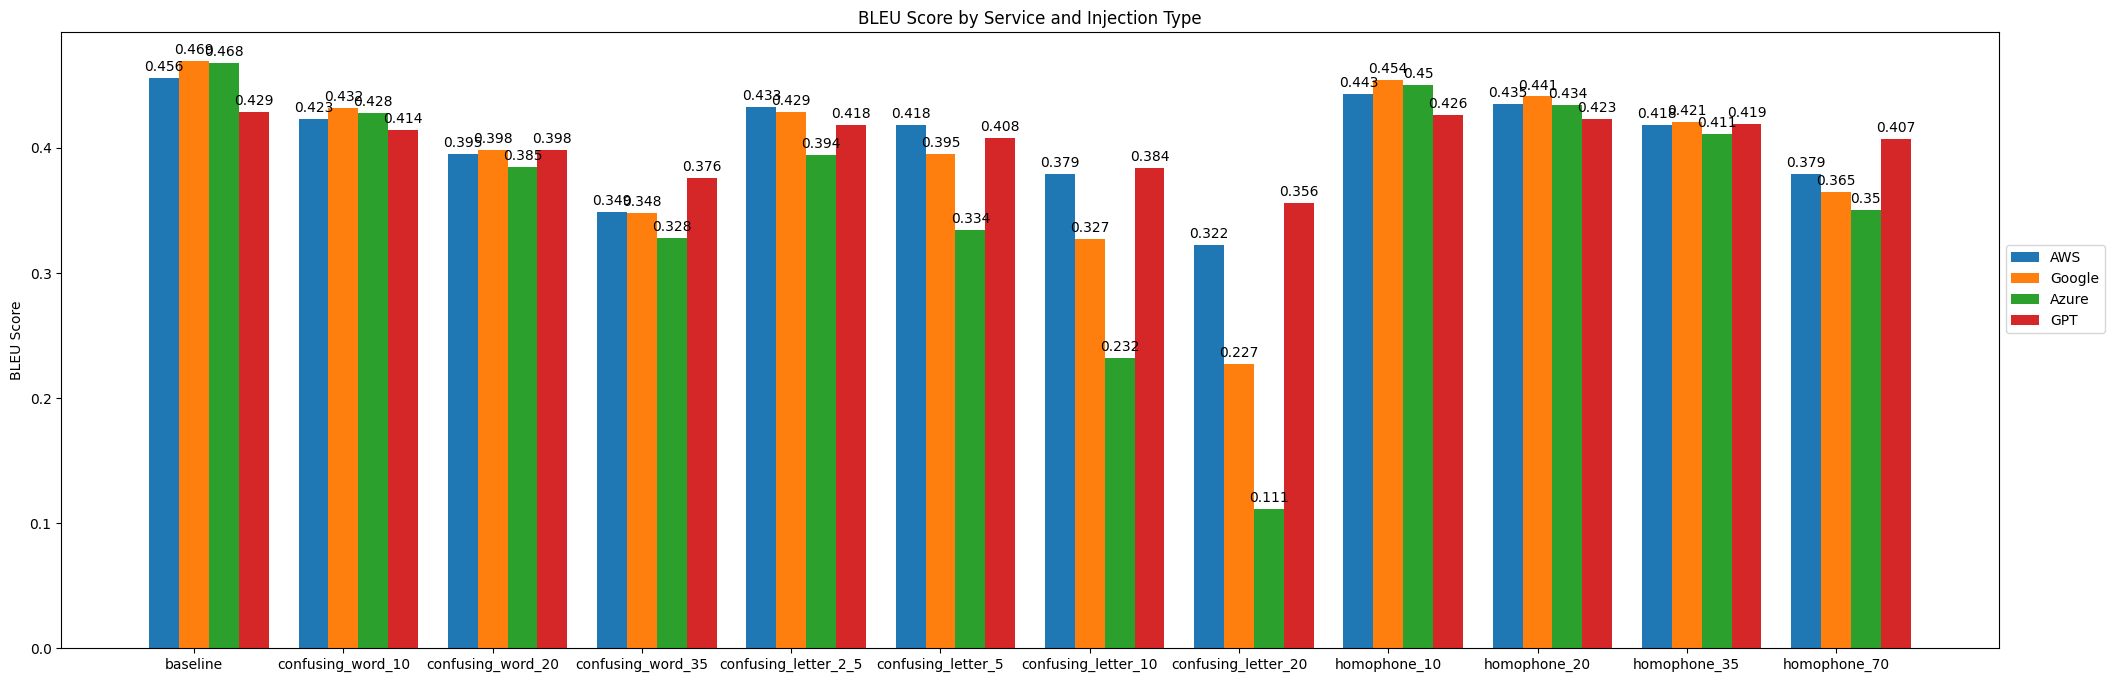

In [25]:
import numpy as np
x_labels = ['baseline', 'confusing_word_10', 'confusing_word_20', 'confusing_word_35', 'confusing_letter_2_5', 'confusing_letter_5', 'confusing_letter_10', 'confusing_letter_20', 'homophone_10', 'homophone_20','homophone_35','homophone_70']
all_data = {
    'AWS': [baseline[0], confusing_word_10[0], confusing_word_20[0], confusing_word_35[0], confusing_letter_2_5[0], confusing_letter_5[0], confusing_letter_10[0], confusing_letter_20[0], homophone_10[0], homophone_20[0], homophone_35[0], homophone_70[0]],
    'Google': [baseline[1], confusing_word_10[1], confusing_word_20[1], confusing_word_35[1], confusing_letter_2_5[1], confusing_letter_5[1], confusing_letter_10[1], confusing_letter_20[1], homophone_10[1], homophone_20[1], homophone_35[1], homophone_70[1]],
    'Azure': [baseline[2], confusing_word_10[2], confusing_word_20[2], confusing_word_35[2], confusing_letter_2_5[2], confusing_letter_5[2], confusing_letter_10[2], confusing_letter_20[2], homophone_10[2], homophone_20[2], homophone_35[2], homophone_70[2]],
    'GPT': [baseline[3], confusing_word_10[3], confusing_word_20[3], confusing_word_35[3], confusing_letter_2_5[3], confusing_letter_5[3], confusing_letter_10[3], confusing_letter_20[3], homophone_10[3], homophone_20[3], homophone_35[3], homophone_70[3]],
}
x = np.arange(len(x_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('BLEU Score')
ax.set_title('BLEU Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width, x_labels)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

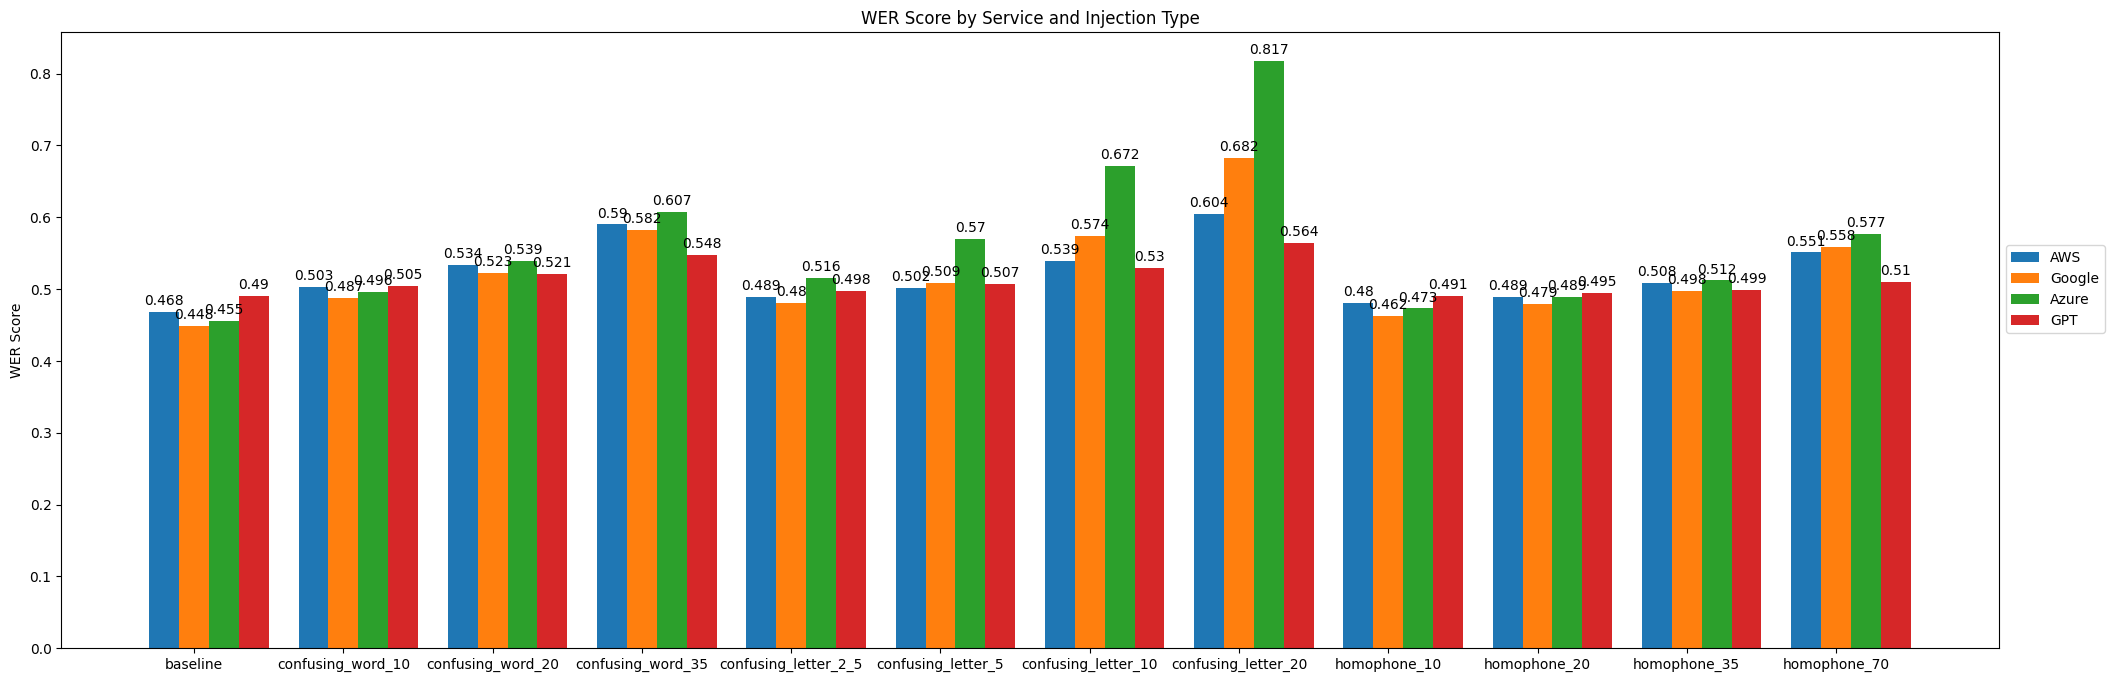

In [26]:
#same of above but for WER
import numpy as np
x_labels = ['baseline', 'confusing_word_10', 'confusing_word_20', 'confusing_word_35', 'confusing_letter_2_5', 'confusing_letter_5', 'confusing_letter_10', 'confusing_letter_20', 'homophone_10', 'homophone_20','homophone_35','homophone_70']
all_data = {
    'AWS': [baseline_wer[0], confusing_word_10_wer[0], confusing_word_20_wer[0], confusing_word_35_wer[0], confusing_letter_2_5_wer[0], confusing_letter_5_wer[0], confusing_letter_10_wer[0], confusing_letter_20_wer[0], homophone_10_wer[0], homophone_20_wer[0], homophone_35_wer[0], homophone_70_wer[0]],
    'Google': [baseline_wer[1], confusing_word_10_wer[1], confusing_word_20_wer[1], confusing_word_35_wer[1], confusing_letter_2_5_wer[1], confusing_letter_5_wer[1], confusing_letter_10_wer[1], confusing_letter_20_wer[1], homophone_10_wer[1], homophone_20_wer[1], homophone_35_wer[1], homophone_70_wer[1]],
    'Azure': [baseline_wer[2], confusing_word_10_wer[2], confusing_word_20_wer[2], confusing_word_35_wer[2], confusing_letter_2_5_wer[2], confusing_letter_5_wer[2], confusing_letter_10_wer[2], confusing_letter_20_wer[2], homophone_10_wer[2], homophone_20_wer[2], homophone_35_wer[2], homophone_70_wer[2]],
    'GPT': [baseline_wer[3], confusing_word_10_wer[3], confusing_word_20_wer[3], confusing_word_35_wer[3], confusing_letter_2_5_wer[3], confusing_letter_5_wer[3], confusing_letter_10_wer[3], confusing_letter_20_wer[3], homophone_10_wer[3], homophone_20_wer[3], homophone_35_wer[3], homophone_70_wer[3]],

}

x = np.arange(len(x_labels))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(figsize=(25, 8))

for label, data in all_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, [round(i,3) for i in data], width, label=label)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('WER Score')
ax.set_title('WER Score by Service and Injection Type')
#center the x ticks
ax.set_xticks(x+width, x_labels)
#make the lengend outside the plot
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()



In [33]:
baseline = [aws_bleu_scores_v1[0]['bleu'], google_bleu_scores_v1[0]['bleu'], azure_bleu_scores_v1[0]['bleu'], gpt_bleu_scores_v1[0]['bleu'], 0]
confusing_word_10 = [aws_bleu_scores_v1[1]['bleu'], google_bleu_scores_v1[1]['bleu'], azure_bleu_scores_v1[1]['bleu'], gpt_bleu_scores_v1[3]['bleu'], confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20 = [aws_bleu_scores_v1[2]['bleu'], google_bleu_scores_v1[2]['bleu'], azure_bleu_scores_v1[2]['bleu'], gpt_bleu_scores_v1[4]['bleu'], confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10 = [aws_bleu_scores_v1[3]['bleu'], google_bleu_scores_v1[3]['bleu'], azure_bleu_scores_v1[3]['bleu'], gpt_bleu_scores_v1[1]['bleu'], letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20 = [aws_bleu_scores_v1[4]['bleu'], google_bleu_scores_v1[4]['bleu'], azure_bleu_scores_v1[4]['bleu'], gpt_bleu_scores_v1[2]['bleu'], letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10 = [aws_bleu_scores_v1[5]['bleu'], google_bleu_scores_v1[5]['bleu'], azure_bleu_scores_v1[5]['bleu'], gpt_bleu_scores_v1[5]['bleu'], homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20 = [aws_bleu_scores_v1[6]['bleu'], google_bleu_scores_v1[6]['bleu'], azure_bleu_scores_v1[6]['bleu'], gpt_bleu_scores_v1[6]['bleu'], homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]

confusing_word_35 = [aws_bleu_scores_v2[1]['bleu'], google_bleu_scores_v2[1]['bleu'], azure_bleu_scores_v2[1]['bleu'], gpt_bleu_scores_v2[2]['bleu'], confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5 = [aws_bleu_scores_v2[0]['bleu'], google_bleu_scores_v2[0]['bleu'], azure_bleu_scores_v2[0]['bleu'], gpt_bleu_scores_v2[1]['bleu'], letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70 = [aws_bleu_scores_v2[3]['bleu'], google_bleu_scores_v2[3]['bleu'], azure_bleu_scores_v2[3]['bleu'], gpt_bleu_scores_v2[4]['bleu'], homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35 = [aws_bleu_scores_v2[2]['bleu'], google_bleu_scores_v2[2]['bleu'], azure_bleu_scores_v2[2]['bleu'], gpt_bleu_scores_v2[3]['bleu'], homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5 = [aws_bleu_scores_v2[4]['bleu'], google_bleu_scores_v2[4]['bleu'], azure_bleu_scores_v2[4]['bleu'], gpt_bleu_scores_v2[0]['bleu'], letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]

In [34]:
#same of above but for WER
baseline_wer = [aws_wer_scores_v1[0], google_wer_scores_v1[0], azure_wer_scores_v1[0], gpt_wer_scores_v1[0], 0]
confusing_word_10_wer = [aws_wer_scores_v1[1], google_wer_scores_v1[1], azure_wer_scores_v1[1], gpt_wer_scores_v1[3], confusing_word[confusing_word['p_confusing_word'] == 0.1].percentage_words_modified.iloc[0]]
confusing_word_20_wer = [aws_wer_scores_v1[2], google_wer_scores_v1[2], azure_wer_scores_v1[2], gpt_wer_scores_v1[4], confusing_word[confusing_word['p_confusing_word'] == 0.2].percentage_words_modified.iloc[0]]
confusing_letter_10_wer = [aws_wer_scores_v1[3], google_wer_scores_v1[3], azure_wer_scores_v1[3], gpt_wer_scores_v1[1], letter[letter['p_letter'] == 0.1].percentage_words_modified.iloc[0]]
confusing_letter_20_wer = [aws_wer_scores_v1[4], google_wer_scores_v1[4], azure_wer_scores_v1[4], gpt_wer_scores_v1[2], letter[letter['p_letter'] == 0.2].percentage_words_modified.iloc[0]]
homophone_10_wer = [aws_wer_scores_v1[5], google_wer_scores_v1[5], azure_wer_scores_v1[5], gpt_wer_scores_v1[5], homophone[homophone['p_homophone'] == 0.1].percentage_words_modified.iloc[0]]
homophone_20_wer = [aws_wer_scores_v1[6], google_wer_scores_v1[6], azure_wer_scores_v1[6], gpt_wer_scores_v1[6], homophone[homophone['p_homophone'] == 0.2].percentage_words_modified.iloc[0]]

confusing_word_35_wer = [aws_wer_scores_v2[1], google_wer_scores_v2[1], azure_wer_scores_v2[1], gpt_wer_scores_v2[2], confusing_word[confusing_word['p_confusing_word'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_5_wer = [aws_wer_scores_v2[0], google_wer_scores_v2[0], azure_wer_scores_v2[0], gpt_wer_scores_v2[1], letter[letter['p_letter'] == 0.05].percentage_words_modified.iloc[0]]
homophone_70_wer = [aws_wer_scores_v2[3], google_wer_scores_v2[3], azure_wer_scores_v2[3], gpt_wer_scores_v2[4], homophone[homophone['p_homophone'] == 0.7].percentage_words_modified.iloc[0]]
homophone_35_wer = [aws_wer_scores_v2[2], google_wer_scores_v2[2], azure_wer_scores_v2[2], gpt_wer_scores_v2[3], homophone[homophone['p_homophone'] == 0.35].percentage_words_modified.iloc[0]]
confusing_letter_2_5_wer = [aws_wer_scores_v2[4], google_wer_scores_v2[4], azure_wer_scores_v2[4], gpt_wer_scores_v2[0], letter[letter['p_letter'] == 0.025].percentage_words_modified.iloc[0]]


In [35]:
# #create pandas df for all bleu scores
# df = pd.DataFrame([baseline, confusing_word_10, confusing_word_20, confusing_word_35, confusing_letter_2_5, confusing_letter_5, confusing_letter_10, confusing_letter_20, homophone_10, homophone_20, homophone_35, homophone_70], columns=['aws', 'google', 'azure', 'gpt', 'percentage_words_modified'])
# df.index = ['baseline', 'confusing_word_10', 'confusing_word_20', 'confusing_word_35', 'confusing_letter_2_5', 'confusing_letter_5', 'confusing_letter_10', 'confusing_letter_20', 'homophone_10', 'homophone_20', 'homophone_35', 'homophone_70']
# df.to_csv("For_graphs/bleu_scores.csv")
# # same for WER
# df_wer = pd.DataFrame([baseline_wer, confusing_word_10_wer, confusing_word_20_wer, confusing_word_35_wer, confusing_letter_2_5_wer, confusing_letter_5_wer, confusing_letter_10_wer, confusing_letter_20_wer, homophone_10_wer, homophone_20_wer, homophone_35_wer, homophone_70_wer], columns=['aws', 'google', 'azure', 'gpt', 'percentage_words_modified'])
# df_wer.index = ['baseline', 'confusing_word_10', 'confusing_word_20', 'confusing_word_35', 'confusing_letter_2_5', 'confusing_letter_5', 'confusing_letter_10', 'confusing_letter_20', 'homophone_10', 'homophone_20', 'homophone_35', 'homophone_70']
# df_wer.to_csv("For_graphs/wer_scores.csv")

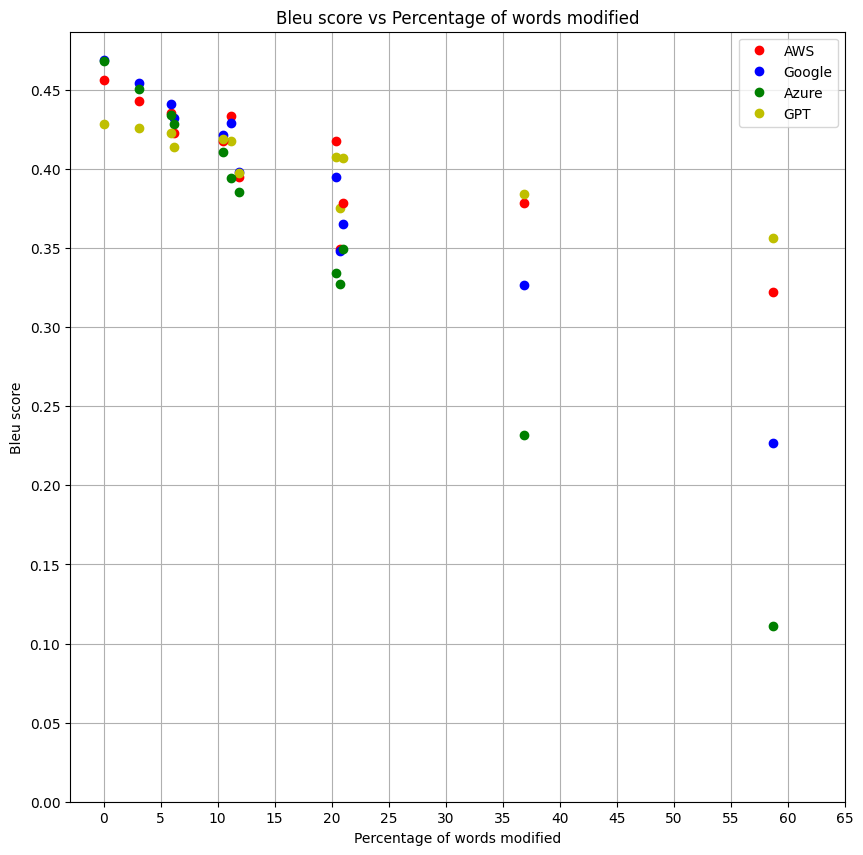

In [30]:
#lets build a scatter plot where x_values are the last value in confusing_word_10 and y_values are all other values in confusing_word_10
all_data = {
    0: baseline,
    confusing_word_10[-1]: confusing_word_10[0:-1],
    confusing_word_20[-1]: confusing_word_20[0:-1],
    confusing_word_35[-1]: confusing_word_35[0:-1],
    confusing_letter_2_5[-1]: confusing_letter_2_5[0:-1],
    confusing_letter_5[-1]: confusing_letter_5[0:-1],
    confusing_letter_10[-1]: confusing_letter_10[0:-1],
    confusing_letter_20[-1]: confusing_letter_20[0:-1],
    confusing_word_35[-1]: confusing_word_35[0:-1],
    homophone_10[-1]: homophone_10[0:-1],
    homophone_20[-1]: homophone_20[0:-1],
    homophone_35[-1]: homophone_35[0:-1],
    homophone_70[-1]: homophone_70[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Bleu score vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('Bleu score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 0.5, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()

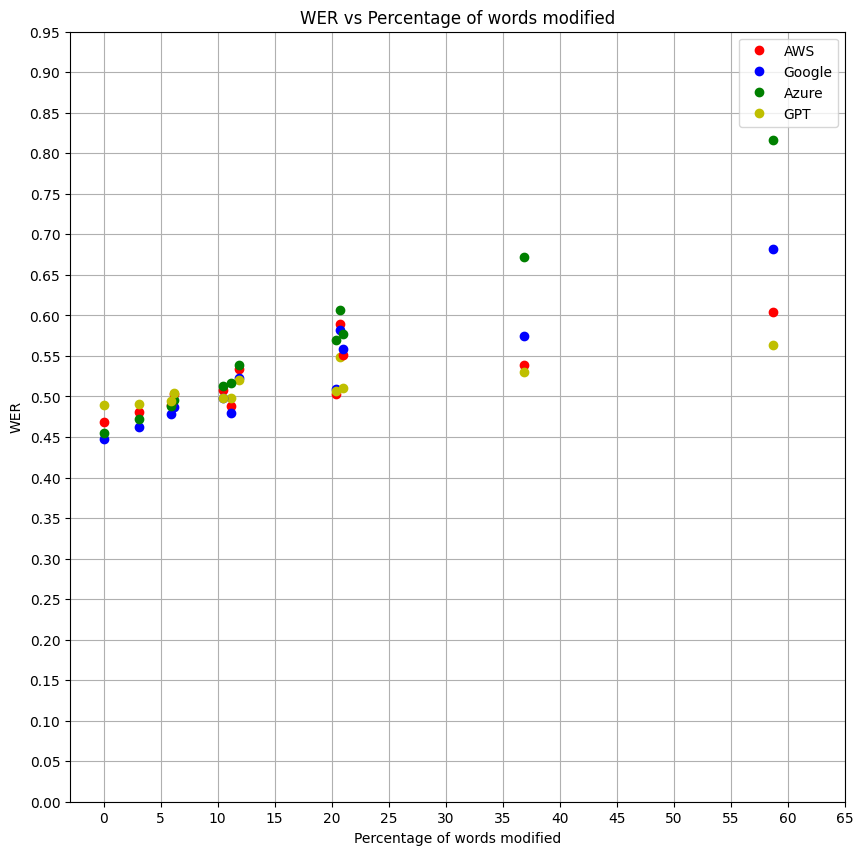

In [31]:
#same of above but for WER
all_data = {
    0: baseline_wer,
    confusing_word_10_wer[-1]: confusing_word_10_wer[0:-1],
    confusing_word_20_wer[-1]: confusing_word_20_wer[0:-1],
    confusing_word_35_wer[-1]: confusing_word_35_wer[0:-1],
    confusing_letter_2_5_wer[-1]: confusing_letter_2_5_wer[0:-1],
    confusing_letter_5_wer[-1]: confusing_letter_5_wer[0:-1],
    confusing_letter_10_wer[-1]: confusing_letter_10_wer[0:-1],
    confusing_letter_20_wer[-1]: confusing_letter_20_wer[0:-1],
    confusing_word_35_wer[-1]: confusing_word_35_wer[0:-1],
    homophone_10_wer[-1]: homophone_10_wer[0:-1],
    homophone_20_wer[-1]: homophone_20_wer[0:-1],
    homophone_35_wer[-1]: homophone_35_wer[0:-1],
    homophone_70_wer[-1]: homophone_70_wer[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('WER vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('WER')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 1.0, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()

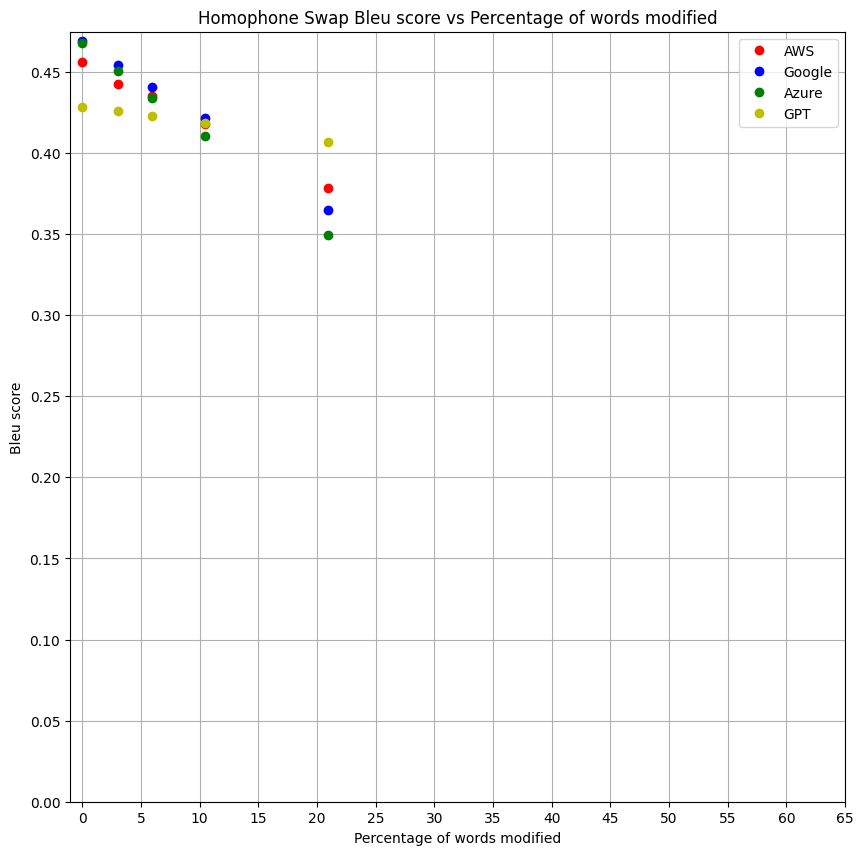

In [32]:
#lets build a scatter plot where x_values are the last value in confusing_word_10 and y_values are all other values in confusing_word_10
all_data = {
    0: baseline,
    homophone_10[-1]: homophone_10[0:-1],
    homophone_20[-1]: homophone_20[0:-1],
    homophone_35[-1]: homophone_35[0:-1],
    homophone_70[-1]: homophone_70[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Homophone Swap Bleu score vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('Bleu score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 0.5, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()

In [33]:
all_data = {
    0: baseline_wer,
    homophone_10_wer[-1]: homophone_10_wer[0:-1],
    homophone_20_wer[-1]: homophone_20_wer[0:-1],
    homophone_35_wer[-1]: homophone_35_wer[0:-1],
    homophone_70_wer[-1]: homophone_70_wer[0:-1],
}

all_data_2_homophone = {
    'AWS': [baseline_wer[0], homophone_10_wer[0], homophone_20_wer[0], homophone_35_wer[0], homophone_70_wer[0]],
    'Google': [baseline_wer[1], homophone_10_wer[1], homophone_20_wer[1], homophone_35_wer[1], homophone_70_wer[1]],
    'Azure': [baseline_wer[2], homophone_10_wer[2], homophone_20_wer[2], homophone_35_wer[2], homophone_70_wer[2]],
    'GPT': [baseline_wer[3], homophone_10_wer[3], homophone_20_wer[3], homophone_35_wer[3], homophone_70_wer[3]],
}
for x, data in all_data_2_homophone.items():
    print(x)
    print(data)

AWS
[0.4680389253834323, 0.4803720047722405, 0.4893702654918139, 0.5080423751958487, 0.5509781655622475]
Google
[0.4476275352527706, 0.46210237318345815, 0.4786327243456137, 0.49823915824577036, 0.5579496614871566]
Azure
[0.4546565280512872, 0.47253805574321894, 0.48859405769811265, 0.5123833891532148, 0.5773261078928833]
GPT
[0.49006022797510385, 0.49131078497606695, 0.494616855208498, 0.4985697652690135, 0.5104716181057655]


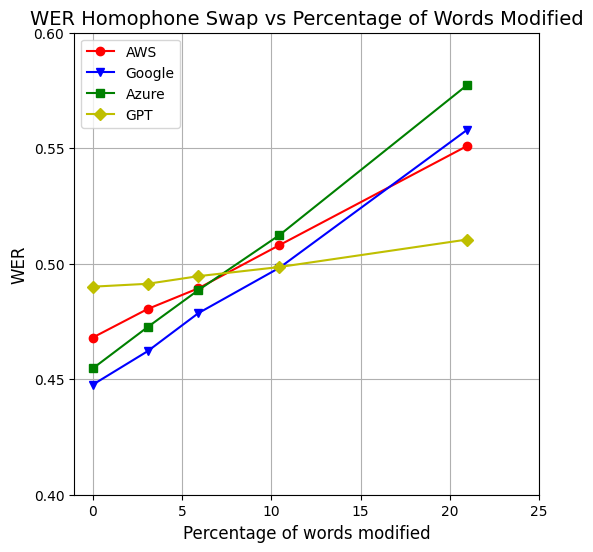

In [34]:
all_data_2_homophone = {
    'AWS': [baseline_wer[0], homophone_10_wer[0], homophone_20_wer[0], homophone_35_wer[0], homophone_70_wer[0]],
    'Google': [baseline_wer[1], homophone_10_wer[1], homophone_20_wer[1], homophone_35_wer[1], homophone_70_wer[1]],
    'Azure': [baseline_wer[2], homophone_10_wer[2], homophone_20_wer[2], homophone_35_wer[2], homophone_70_wer[2]],
    'GPT': [baseline_wer[3], homophone_10_wer[3], homophone_20_wer[3], homophone_35_wer[3], homophone_70_wer[3]],
}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, homophone_10_wer[-1], homophone_20_wer[-1], homophone_35_wer[-1], homophone_70_wer[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_homophone.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('WER Homophone Swap vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('WER', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.4, 0.65, 0.05))
ax.set_xticks(np.arange(0, 30, 5))
#show grid
ax.grid(True)

#save as png
plt.savefig('wer_homophone_swap.png')
plt.show()

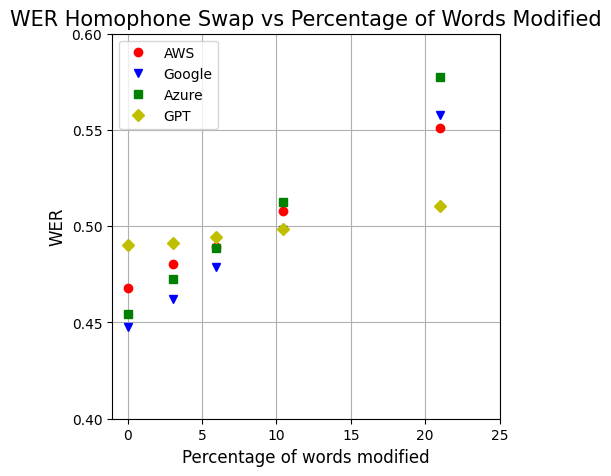

In [35]:
#same of above but for WER
all_data = {
    0: baseline_wer,
    homophone_10_wer[-1]: homophone_10_wer[0:-1],
    homophone_20_wer[-1]: homophone_20_wer[0:-1],
    homophone_35_wer[-1]: homophone_35_wer[0:-1],
    homophone_70_wer[-1]: homophone_70_wer[0:-1],
}

fig, ax = plt.subplots(figsize=(5,5))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = marker_type[counter], linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('WER Homophone Swap vs Percentage of Words Modified', fontsize=15)
ax.set_xlabel('Percentage of words modified', fontsize=12)
ax.set_ylabel('WER', fontsize=12)
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.4, 0.65, 0.05))
ax.set_xticks(np.arange(0, 30, 5))
#show grid
ax.grid(True)

#make plot smaller
plt.show()


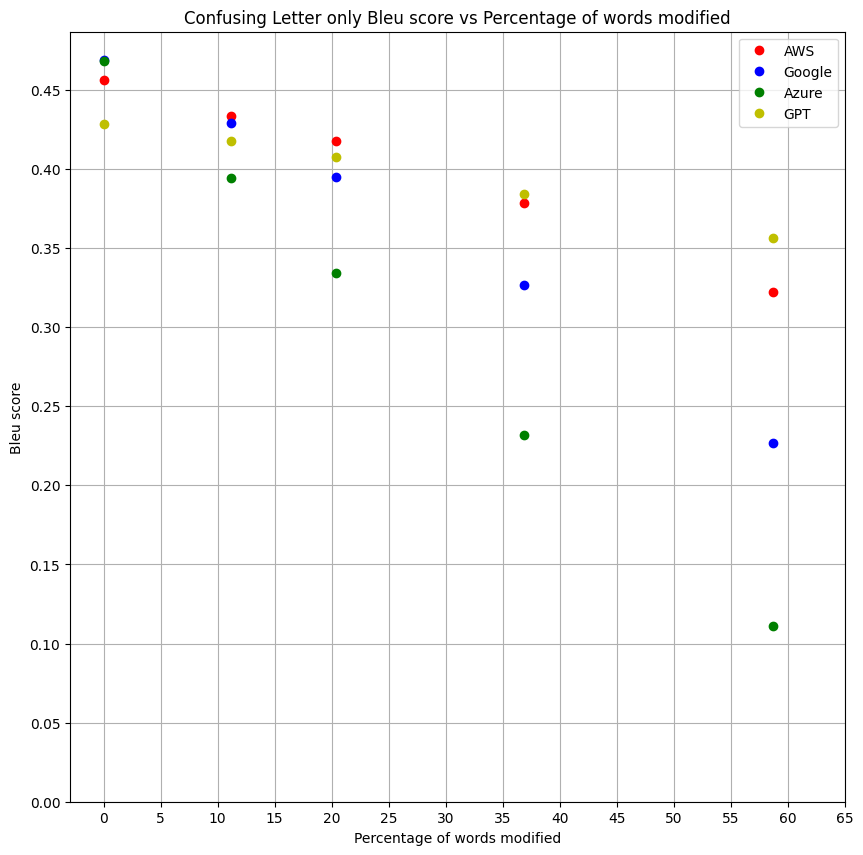

In [36]:
#lets build a scatter plot where x_values are the last value in confusing_word_10 and y_values are all other values in confusing_word_10
all_data = {
    0: baseline,
    confusing_letter_2_5[-1]: confusing_letter_2_5[0:-1],
    confusing_letter_5[-1]: confusing_letter_5[0:-1],
    confusing_letter_10[-1]: confusing_letter_10[0:-1],
    confusing_letter_20[-1]: confusing_letter_20[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Letter only Bleu score vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('Bleu score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 0.5, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()

In [37]:
all_data_2_confusing_letter = {
    'AWS': [baseline[0], confusing_letter_2_5[0], confusing_letter_5[0], confusing_letter_10[0], confusing_letter_20[0]],
    'Google': [baseline[1], confusing_letter_2_5[1], confusing_letter_5[1], confusing_letter_10[1], confusing_letter_20[1]],
    'Azure': [baseline[2], confusing_letter_2_5[2], confusing_letter_5[2], confusing_letter_10[2], confusing_letter_20[2]],
    'GPT': [baseline[3], confusing_letter_2_5[3], confusing_letter_5[3], confusing_letter_10[3], confusing_letter_20[3]],

}

for x, data in all_data_2_confusing_letter.items():
    print(x)
    print(data)

AWS
[0.4561216039012071, 0.4333745816255321, 0.4176597514390514, 0.37871001647624586, 0.32217535818905696]
Google
[0.468849057109288, 0.4293313178138173, 0.3950420951080804, 0.3266538631479847, 0.2266752915565537]
Azure
[0.4679898124004757, 0.394117806787871, 0.3341500279418801, 0.2318586479176728, 0.1112617703933775]
GPT
[0.4285416340728897, 0.41753950895732683, 0.407587370888209, 0.384124412607989, 0.35604968181957347]


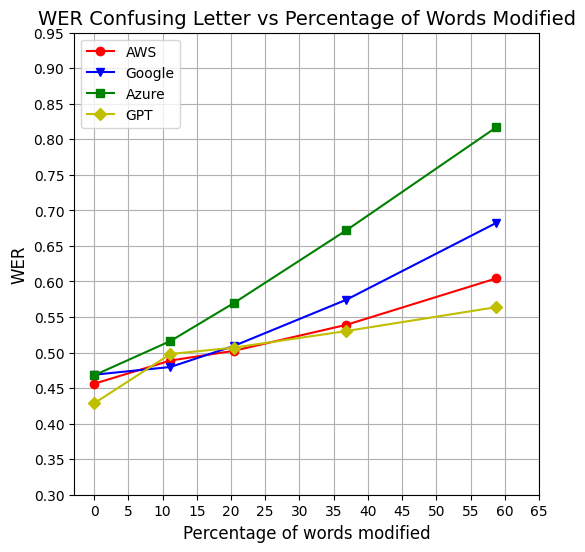

In [38]:
all_data_2_confusing_letter = {
    'AWS': [baseline[0], confusing_letter_2_5_wer[0], confusing_letter_5_wer[0], confusing_letter_10_wer[0], confusing_letter_20_wer[0]],
    'Google': [baseline[1], confusing_letter_2_5_wer[1], confusing_letter_5_wer[1], confusing_letter_10_wer[1], confusing_letter_20_wer[1]],
    'Azure': [baseline[2], confusing_letter_2_5_wer[2], confusing_letter_5_wer[2], confusing_letter_10_wer[2], confusing_letter_20_wer[2]],
    'GPT': [baseline[3], confusing_letter_2_5_wer[3], confusing_letter_5_wer[3], confusing_letter_10_wer[3], confusing_letter_20_wer[3]],

}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_letter_2_5_wer[-1], confusing_letter_5_wer[-1], confusing_letter_10_wer[-1], confusing_letter_20_wer[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_letter.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('WER Confusing Letter vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('WER', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.30, 1, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)

#make plot smaller
plt.show()
#save plot as png
fig.savefig('confusing_letter_wer.png', bbox_inches='tight')

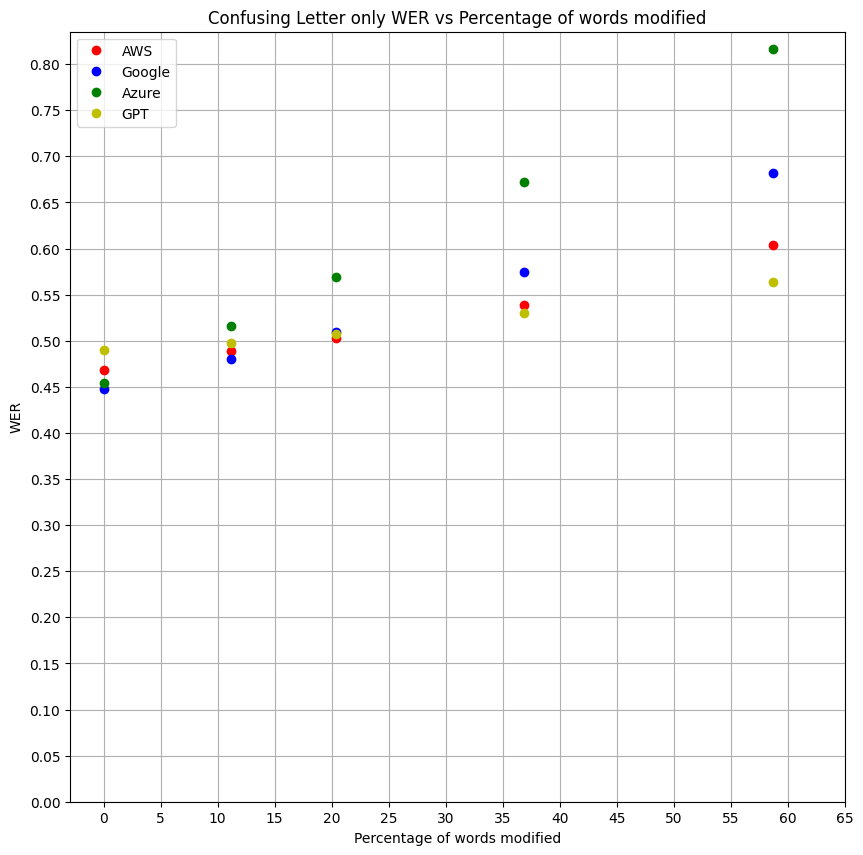

In [39]:
#same of above but for WER
all_data = {
    0: baseline_wer,
    confusing_letter_2_5_wer[-1]: confusing_letter_2_5_wer[0:-1],
    confusing_letter_5_wer[-1]: confusing_letter_5_wer[0:-1],
    confusing_letter_10_wer[-1]: confusing_letter_10_wer[0:-1],
    confusing_letter_20_wer[-1]: confusing_letter_20_wer[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Letter only WER vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('WER')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 0.85, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()


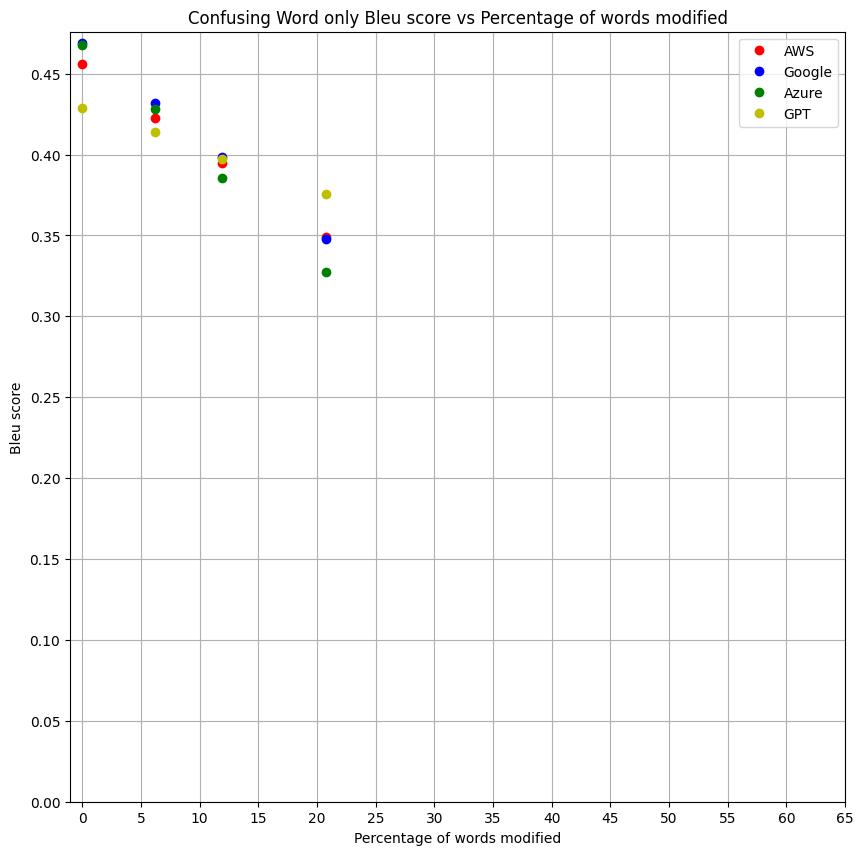

In [40]:
#lets build a scatter plot where x_values are the last value in confusing_word_10 and y_values are all other values in confusing_word_10
all_data = {
    0: baseline,
    confusing_word_10[-1]: confusing_word_10[0:-1],
    confusing_word_20[-1]: confusing_word_20[0:-1],
    confusing_word_35[-1]: confusing_word_35[0:-1],
}


fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Word only Bleu score vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('Bleu score')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 0.5, 0.05))
ax.set_xticks(np.arange(0, 70, 5))
#show grid
ax.grid(True)
plt.show()

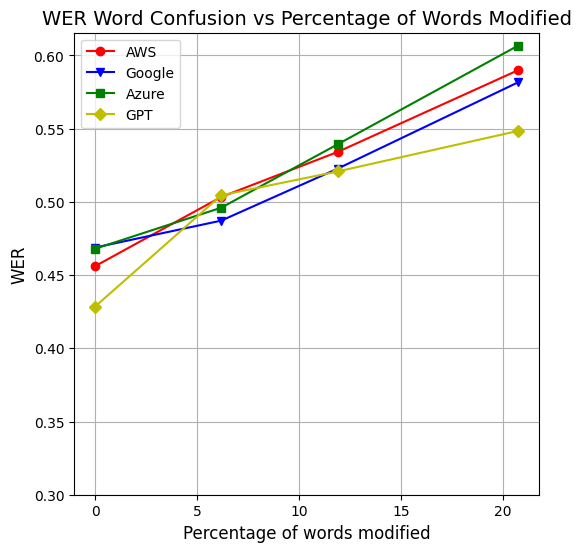

In [41]:
all_data_2_confusing_word = {
    'AWS': [baseline[0], confusing_word_10_wer[0], confusing_word_20_wer[0], confusing_word_35_wer[0]],
    'Google': [baseline[1], confusing_word_10_wer[1], confusing_word_20_wer[1], confusing_word_35_wer[1]],
    'Azure': [baseline[2], confusing_word_10_wer[2], confusing_word_20_wer[2], confusing_word_35_wer[2]],
    'GPT': [baseline[3], confusing_word_10_wer[3], confusing_word_20_wer[3], confusing_word_35_wer[3]],
}

fig, ax = plt.subplots(figsize=(6,6))
services =['AWS', 'Google', 'Azure', 'GPT']
word_change_percentage = [0, confusing_word_10_wer[-1], confusing_word_20_wer[-1], confusing_word_35_wer[-1]]
colours = ['r', 'b', 'g', 'y']
counter = 0
marker_type = ['o', 'v', 's', 'D']
for x, data in all_data_2_confusing_word.items():
    rects = ax.plot(word_change_percentage, data, marker =marker_type[counter],linestyle='solid', label=services[counter], c=colours[counter])
    counter+=1
ax.set_title('WER Word Confusion vs Percentage of Words Modified', fontsize=14, fontweight='normal')
ax.set_xlabel('Percentage of words modified', fontsize=12, fontweight='normal')
ax.set_ylabel('WER', fontsize=12, fontweight='normal')
ax.legend(services, fontsize=10)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0.30, 0.65, 0.05))
ax.set_xticks(np.arange(0, 25, 5))
#show grid
ax.grid(True)

#make plot smaller
#save as png
fig.savefig('confusing_word_wer.png', bbox_inches='tight')
plt.show()

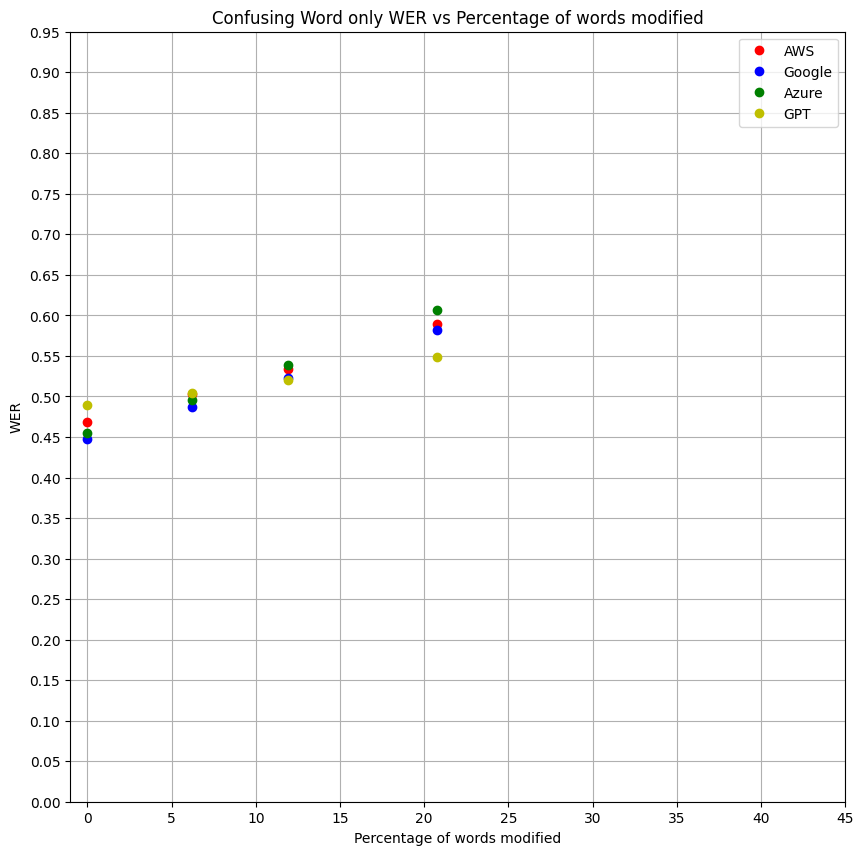

In [42]:
#same of above but for WER
all_data = {
    0: baseline_wer,
    confusing_word_10_wer[-1]: confusing_word_10_wer[0:-1],
    confusing_word_20_wer[-1]: confusing_word_20_wer[0:-1],
    confusing_word_35_wer[-1]: confusing_word_35_wer[0:-1],
}

fig, ax = plt.subplots(figsize=(10,10))
services =['AWS', 'Google', 'Azure', 'GPT']
colours = ['r', 'b', 'g', 'y']
for x, data in all_data.items():
    counter = 0
    for i in data:
        rects = ax.plot(x, i, marker = 'o',linestyle='', label=services[counter], c=colours[counter])
        counter+=1
ax.set_title('Confusing Word only WER vs Percentage of words modified')
ax.set_xlabel('Percentage of words modified')
ax.set_ylabel('WER')
ax.legend(services)
#make y axis have intervals of 0.01
ax.set_yticks(np.arange(0, 1.0, 0.05))
ax.set_xticks(np.arange(0, 50, 5))
#show grid
ax.grid(True)
plt.show()
